In [1]:
!pip install pandas matplotlib seaborn numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 10.3 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 11.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 11.0 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 11.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 10.7 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [seaborn]0/12 [matplotlib]


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from pathlib import Path

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("=== FIRECRACKER RESOURCE CONTENTION IO PERFORMANCE ANALYSIS ===\n")

# Load all CSV files
csv_files = glob.glob("detailed_io_results_*.csv")
csv_files.sort()

print(f"Found {len(csv_files)} result files:")
for file in csv_files:
    print(f"  - {file}")
print()

# Read and combine all data
all_data = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        all_data.append(df)
        print(f"Loaded {len(df)} records from {file}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

if not all_data:
    print("No data files could be loaded!")
    exit()

# Combine all dataframes
df = pd.concat(all_data, ignore_index=True)
print(f"\nTotal records loaded: {len(df)}")
print(f"Test scenarios: {df['test_name'].unique()}")
print(f"IO patterns: {df['io_pattern'].unique()}")
print(f"Operations: {df['operation'].unique()}")

=== FIRECRACKER RESOURCE CONTENTION IO PERFORMANCE ANALYSIS ===

Found 6 result files:
  - detailed_io_results_baseline_1755784689.csv
  - detailed_io_results_heavy_cpu_contention_1755784790.csv
  - detailed_io_results_light_cpu_contention_1755784740.csv
  - detailed_io_results_memory_pressure_1755784860.csv
  - detailed_io_results_pinned_to_0_1_1755784913.csv
  - detailed_io_results_single_core_contention_1755784965.csv

Loaded 11 records from detailed_io_results_baseline_1755784689.csv
Loaded 14 records from detailed_io_results_heavy_cpu_contention_1755784790.csv
Loaded 12 records from detailed_io_results_light_cpu_contention_1755784740.csv
Loaded 13 records from detailed_io_results_memory_pressure_1755784860.csv
Loaded 11 records from detailed_io_results_pinned_to_0_1_1755784913.csv
Loaded 12 records from detailed_io_results_single_core_contention_1755784965.csv

Total records loaded: 73
Test scenarios: ['baseline' 'heavy_cpu_contention' 'light_cpu_contention'
 'memory_pressure' 'pi

In [10]:
# Data quality check and cleanup
print("\n=== DATA QUALITY ANALYSIS ===")

# Check for any anomalous values (negative latencies, extreme outliers)
print("Checking for data quality issues...")

# Identify problematic records
problematic_latency = df[df['mean_latency_ms'] < 0]
problematic_throughput = df[df['mean_throughput_mbps'] < 0]
extreme_cv = df[df['cv_latency_pct'] > 1000]

print(f"Records with negative latency: {len(problematic_latency)}")
print(f"Records with negative throughput: {len(problematic_throughput)}")
print(f"Records with extreme CV% (>1000%): {len(extreme_cv)}")

if len(problematic_latency) > 0:
    print("\nProblematic latency records:")
    print(problematic_latency[['test_name', 'io_pattern', 'operation', 'mean_latency_ms', 'min_latency_ms']])

# Clean the data - remove obviously erroneous records
df_clean = df[
    (df['mean_latency_ms'] > 0) & 
    (df['mean_throughput_mbps'] > 0) & 
    (df['cv_latency_pct'] < 1000)
].copy()

print(f"\nCleaned dataset: {len(df_clean)} records (removed {len(df) - len(df_clean)} problematic records)")


=== DATA QUALITY ANALYSIS ===
Checking for data quality issues...
Records with negative latency: 0
Records with negative throughput: 0
Records with extreme CV% (>1000%): 0

Cleaned dataset: 73 records (removed 0 problematic records)


In [11]:
# 1. COMPREHENSIVE PERFORMANCE OVERVIEW
print("\n=== 1. COMPREHENSIVE PERFORMANCE OVERVIEW ===")

# Summary statistics by test scenario
summary_stats = df_clean.groupby('test_name').agg({
    'mean_latency_ms': ['mean', 'std', 'min', 'max'],
    'mean_throughput_mbps': ['mean', 'std', 'min', 'max'],
    'cv_latency_pct': ['mean', 'std'],
    'cv_throughput_pct': ['mean', 'std'],
    'mean_iops': ['mean', 'std']
}).round(2)

print("Performance Summary by Test Scenario:")
print(summary_stats)

# Create performance comparison table
performance_comparison = df_clean.groupby(['test_name', 'operation']).agg({
    'mean_latency_ms': 'mean',
    'mean_throughput_mbps': 'mean', 
    'cv_latency_pct': 'mean',
    'cv_throughput_pct': 'mean',
    'mean_iops': 'mean'
}).round(2)

print("\n\nPerformance by Scenario and Operation:")
print(performance_comparison)


=== 1. COMPREHENSIVE PERFORMANCE OVERVIEW ===
Performance Summary by Test Scenario:
                       mean_latency_ms                         \
                                  mean    std     min     max   
test_name                                                       
baseline                        183.25  48.62   51.75  238.00   
heavy_cpu_contention            355.75  48.11  315.66  469.58   
light_cpu_contention            196.65  37.47   96.91  255.30   
memory_pressure                 225.10  44.77  192.13  338.23   
pinned_to_0_1                   195.52  51.77   55.38  256.49   
single_core_contention          207.50  20.60  188.54  256.38   

                       mean_throughput_mbps                        \
                                       mean     std    min    max   
test_name                                                           
baseline                             395.57  348.70  16.86  928.6   
heavy_cpu_contention                 242.52  203.85  


=== 2. DETAILED LATENCY ANALYSIS ===


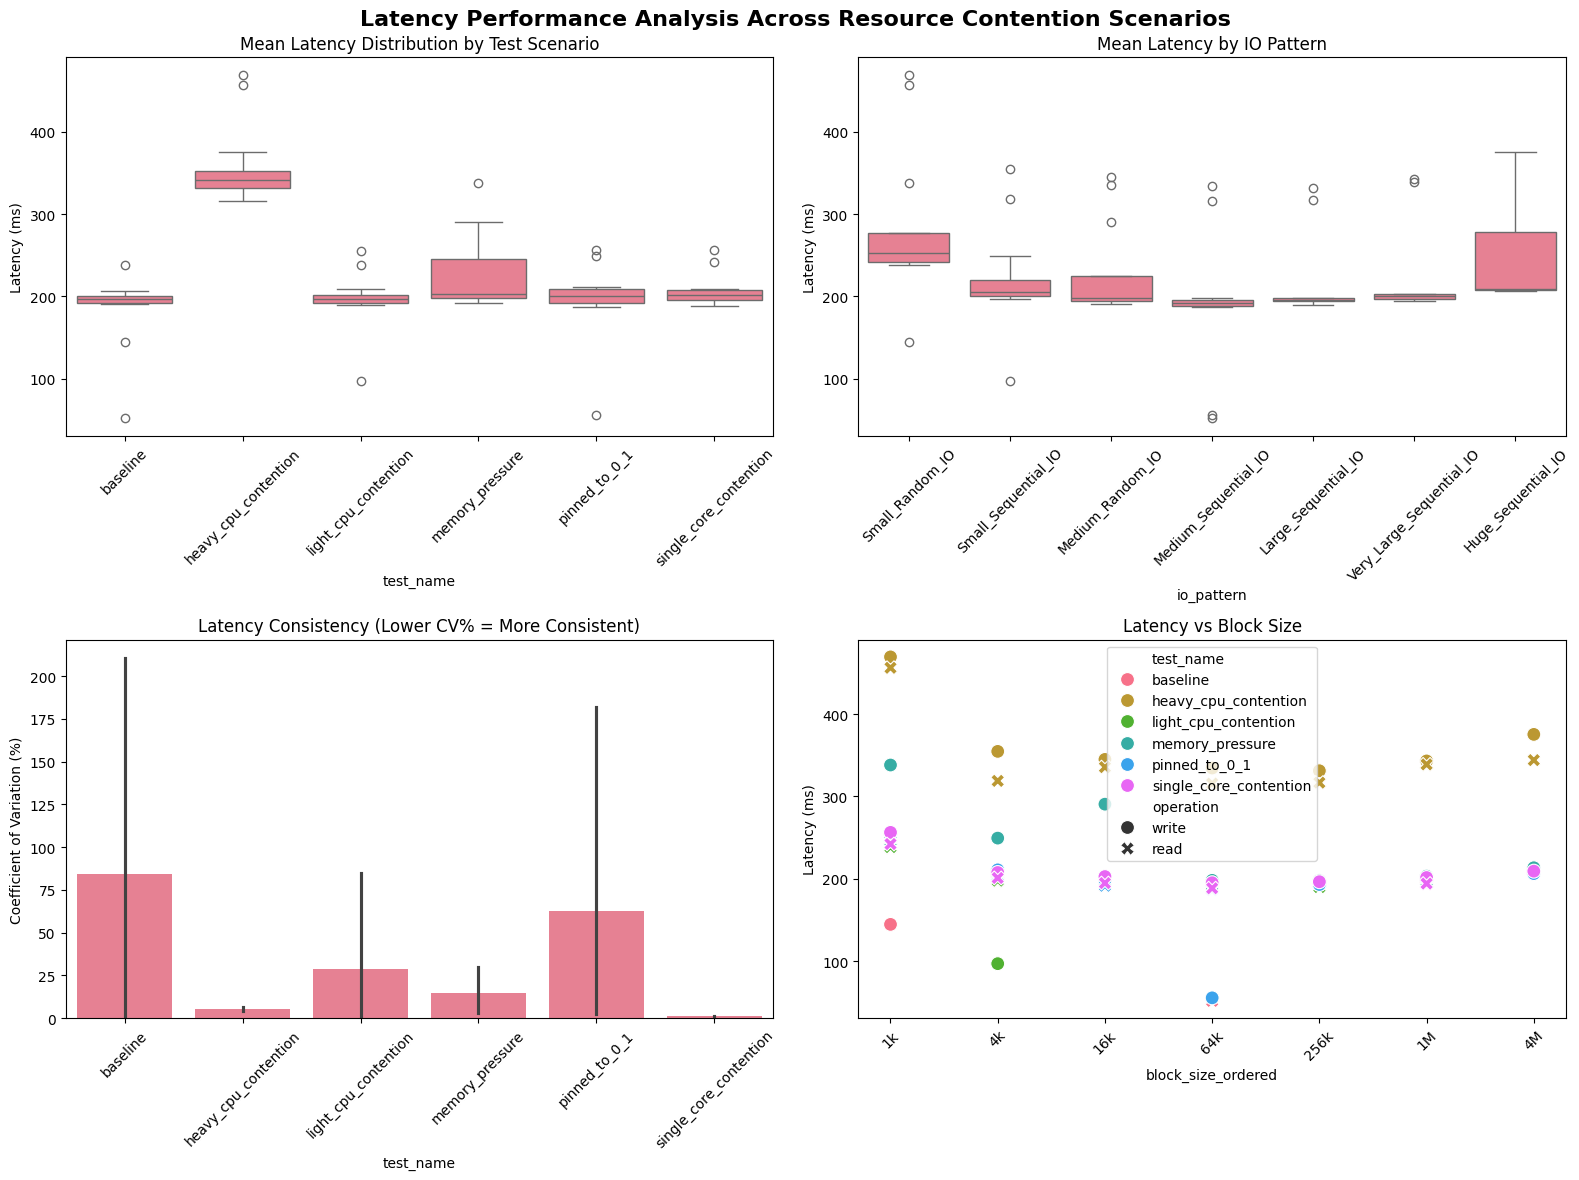


Latency Statistics by Test Scenario:
                        count    mean    std     min     25%     50%     75%  \
test_name                                                                      
baseline                 11.0  183.25  48.62   51.75  192.20  196.96  200.65   
heavy_cpu_contention     14.0  355.75  48.11  315.66  332.10  341.08  352.36   
light_cpu_contention     12.0  196.65  37.47   96.91  192.57  196.86  202.04   
memory_pressure          13.0  225.10  44.77  192.13  197.53  203.21  245.96   
pinned_to_0_1            11.0  195.52  51.77   55.38  192.32  200.23  208.61   
single_core_contention   12.0  207.50  20.60  188.54  195.09  201.28  208.04   

                           max  
test_name                       
baseline                238.00  
heavy_cpu_contention    469.58  
light_cpu_contention    255.30  
memory_pressure         338.23  
pinned_to_0_1           256.49  
single_core_contention  256.38  


In [12]:
# 2. LATENCY ANALYSIS WITH VISUALIZATIONS
print("\n=== 2. DETAILED LATENCY ANALYSIS ===")

# Create subplots for latency analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Latency Performance Analysis Across Resource Contention Scenarios', fontsize=16, fontweight='bold')

# Latency by test scenario
sns.boxplot(data=df_clean, x='test_name', y='mean_latency_ms', ax=axes[0,0])
axes[0,0].set_title('Mean Latency Distribution by Test Scenario')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylabel('Latency (ms)')

# Latency by IO pattern
sns.boxplot(data=df_clean, x='io_pattern', y='mean_latency_ms', ax=axes[0,1])
axes[0,1].set_title('Mean Latency by IO Pattern')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylabel('Latency (ms)')

# Latency consistency (CV%) by scenario
sns.barplot(data=df_clean, x='test_name', y='cv_latency_pct', ax=axes[1,0])
axes[1,0].set_title('Latency Consistency (Lower CV% = More Consistent)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylabel('Coefficient of Variation (%)')

# Latency vs Block Size
block_size_order = ['1k', '4k', '16k', '64k', '256k', '1M', '4M']
df_clean['block_size_ordered'] = pd.Categorical(df_clean['block_size'], categories=block_size_order, ordered=True)
sns.scatterplot(data=df_clean, x='block_size_ordered', y='mean_latency_ms', 
                hue='test_name', style='operation', s=100, ax=axes[1,1])
axes[1,1].set_title('Latency vs Block Size')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylabel('Latency (ms)')

plt.tight_layout()
plt.show()

# Latency statistics by scenario
latency_stats = df_clean.groupby('test_name')['mean_latency_ms'].describe()
print("\nLatency Statistics by Test Scenario:")
print(latency_stats.round(2))


=== 3. DETAILED THROUGHPUT ANALYSIS ===


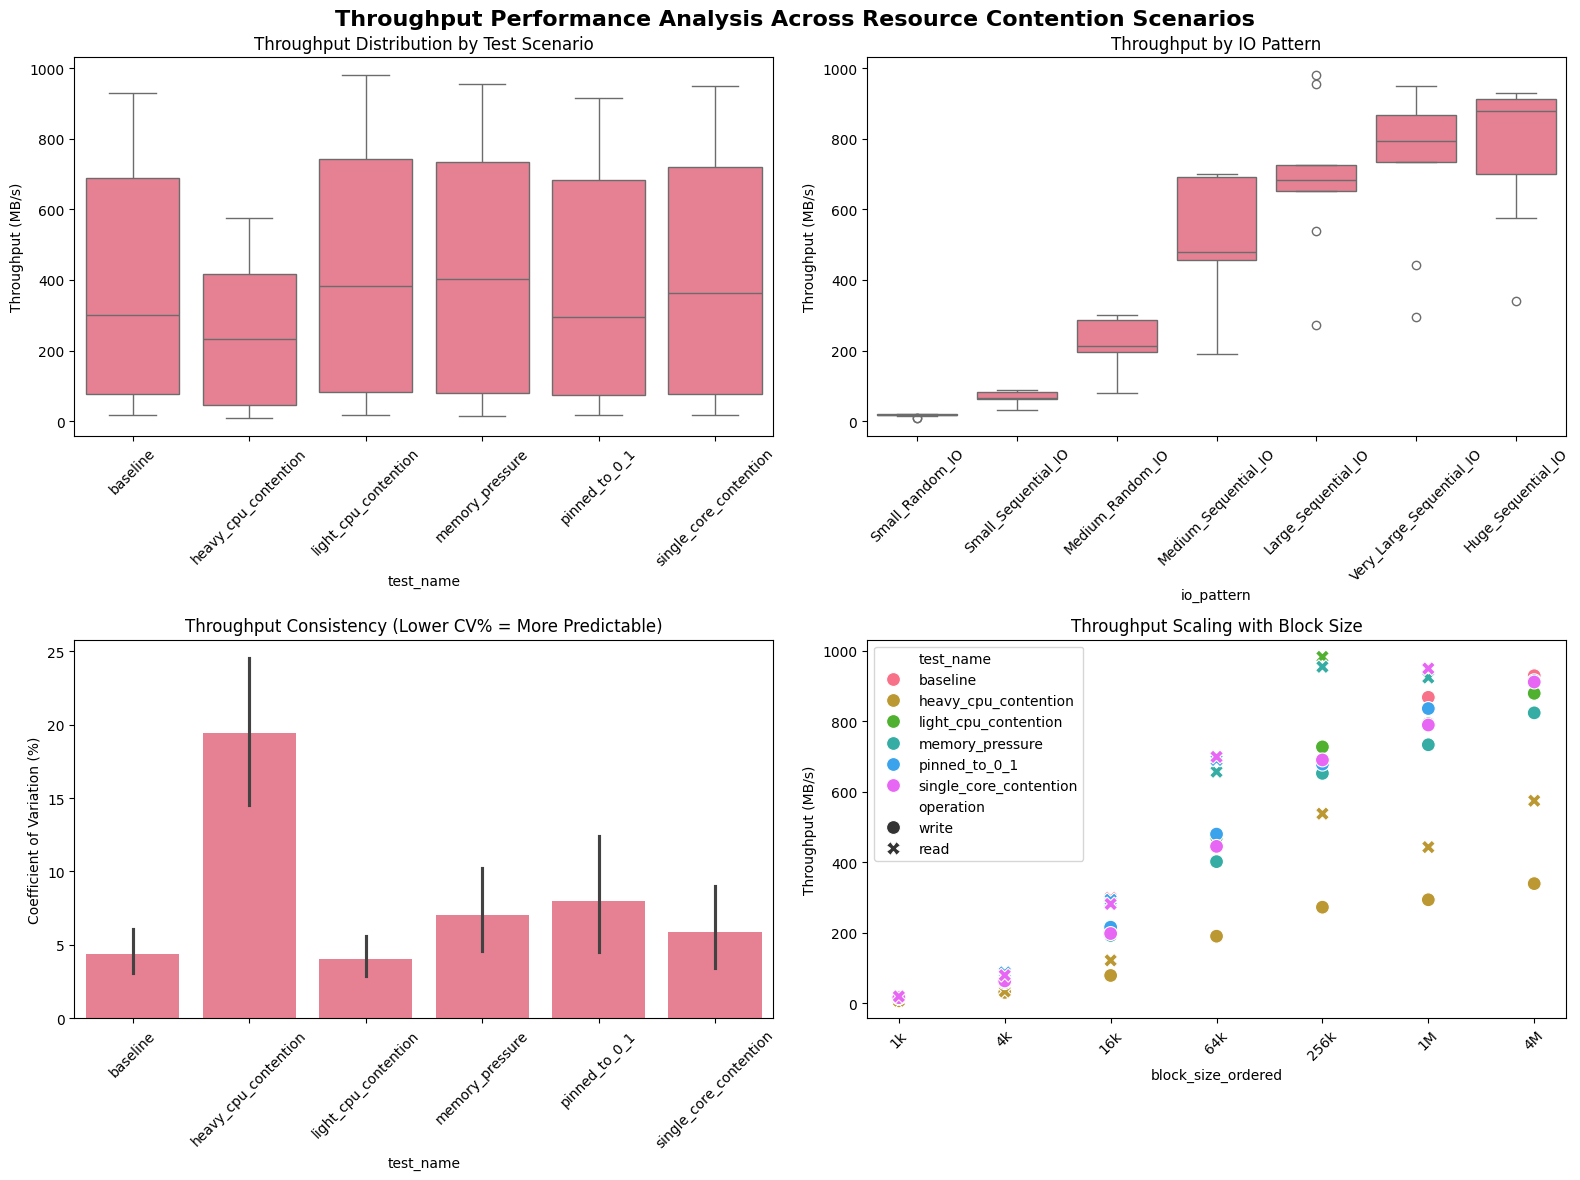


Baseline average throughput: 395.57 MB/s

Throughput Impact Analysis:
  heavy_cpu_contention: 242.52 MB/s (-38.7% vs baseline)
  light_cpu_contention: 436.40 MB/s (+10.3% vs baseline)
  memory_pressure: 446.09 MB/s (+12.8% vs baseline)
  pinned_to_0_1: 390.34 MB/s (-1.3% vs baseline)
  single_core_contention: 428.60 MB/s (+8.3% vs baseline)


In [13]:
# 3. THROUGHPUT ANALYSIS WITH VISUALIZATIONS
print("\n=== 3. DETAILED THROUGHPUT ANALYSIS ===")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Throughput Performance Analysis Across Resource Contention Scenarios', fontsize=16, fontweight='bold')

# Throughput by test scenario
sns.boxplot(data=df_clean, x='test_name', y='mean_throughput_mbps', ax=axes[0,0])
axes[0,0].set_title('Throughput Distribution by Test Scenario')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylabel('Throughput (MB/s)')

# Throughput by IO pattern
sns.boxplot(data=df_clean, x='io_pattern', y='mean_throughput_mbps', ax=axes[0,1])
axes[0,1].set_title('Throughput by IO Pattern')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylabel('Throughput (MB/s)')

# Throughput consistency
sns.barplot(data=df_clean, x='test_name', y='cv_throughput_pct', ax=axes[1,0])
axes[1,0].set_title('Throughput Consistency (Lower CV% = More Predictable)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylabel('Coefficient of Variation (%)')

# Throughput scaling with block size
sns.scatterplot(data=df_clean, x='block_size_ordered', y='mean_throughput_mbps', 
                hue='test_name', style='operation', s=100, ax=axes[1,1])
axes[1,1].set_title('Throughput Scaling with Block Size')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylabel('Throughput (MB/s)')

plt.tight_layout()
plt.show()

# Throughput impact analysis
baseline_throughput = df_clean[df_clean['test_name'] == 'baseline']['mean_throughput_mbps'].mean()
print(f"\nBaseline average throughput: {baseline_throughput:.2f} MB/s")

print("\nThroughput Impact Analysis:")
for scenario in df_clean['test_name'].unique():
    if scenario != 'baseline':
        scenario_throughput = df_clean[df_clean['test_name'] == scenario]['mean_throughput_mbps'].mean()
        impact = ((scenario_throughput - baseline_throughput) / baseline_throughput) * 100
        print(f"  {scenario}: {scenario_throughput:.2f} MB/s ({impact:+.1f}% vs baseline)")


=== 4. IOPS (Input/Output Operations Per Second) ANALYSIS ===


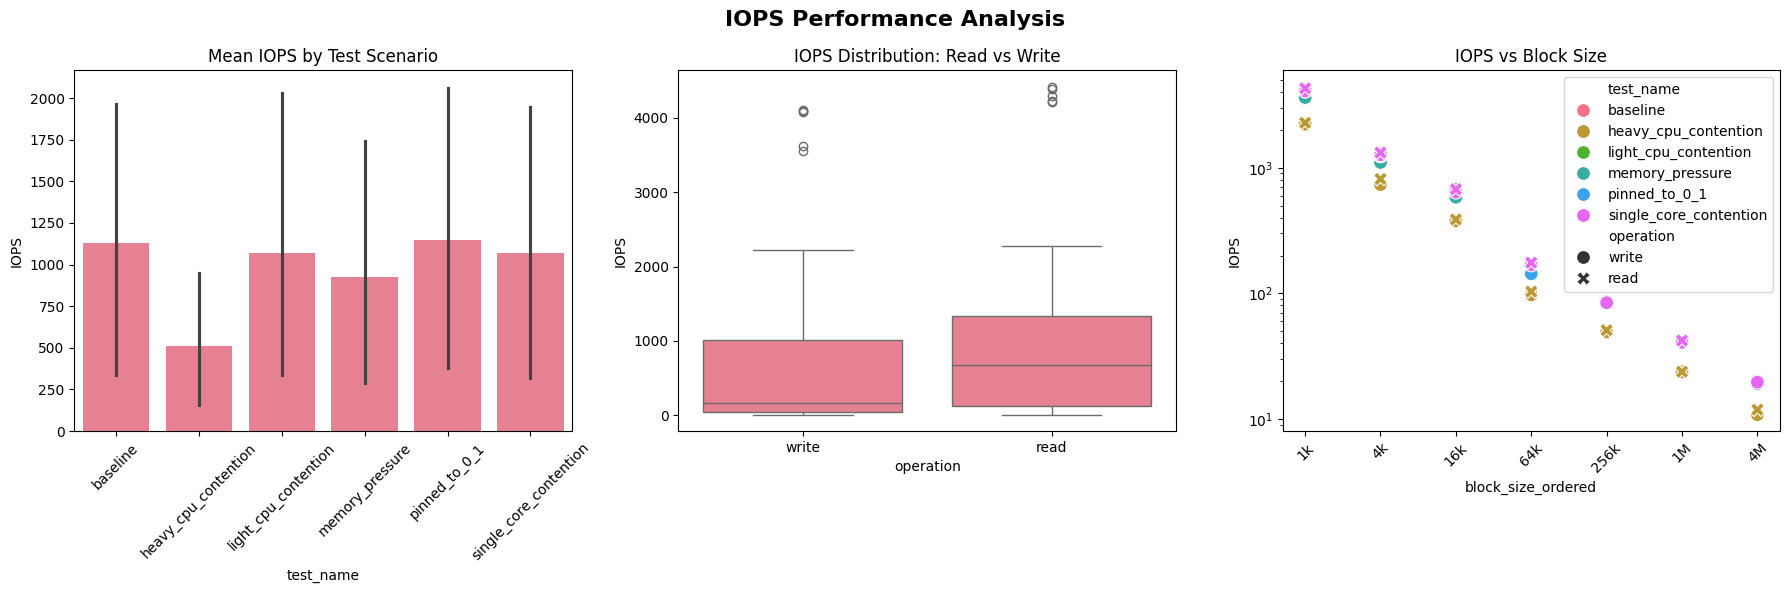

IOPS Statistics by Test Scenario:
                           mean      std    min      max
test_name                                               
baseline                1127.23  1499.97  19.81  4415.07
heavy_cpu_contention     513.29   783.00  10.81  2281.13
light_cpu_contention    1070.89  1543.93  19.62  4377.97
memory_pressure          927.24  1395.96  19.04  4216.77
pinned_to_0_1           1150.42  1550.38  20.00  4208.90
single_core_contention  1066.72  1527.46  19.62  4286.70


In [14]:
# 4. IOPS ANALYSIS
print("\n=== 4. IOPS (Input/Output Operations Per Second) ANALYSIS ===")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('IOPS Performance Analysis', fontsize=16, fontweight='bold')

# IOPS by scenario
sns.barplot(data=df_clean, x='test_name', y='mean_iops', ax=axes[0])
axes[0].set_title('Mean IOPS by Test Scenario')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylabel('IOPS')

# IOPS by operation type
sns.boxplot(data=df_clean, x='operation', y='mean_iops', ax=axes[1])
axes[1].set_title('IOPS Distribution: Read vs Write')
axes[1].set_ylabel('IOPS')

# IOPS vs Block Size (log scale for better visualization)
sns.scatterplot(data=df_clean, x='block_size_ordered', y='mean_iops', 
                hue='test_name', style='operation', s=100, ax=axes[2])
axes[2].set_title('IOPS vs Block Size')
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_ylabel('IOPS')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

# IOPS statistics
iops_by_scenario = df_clean.groupby('test_name')['mean_iops'].agg(['mean', 'std', 'min', 'max']).round(2)
print("IOPS Statistics by Test Scenario:")
print(iops_by_scenario)


=== 5. PERFORMANCE CONSISTENCY (VARIABILITY) ANALYSIS ===


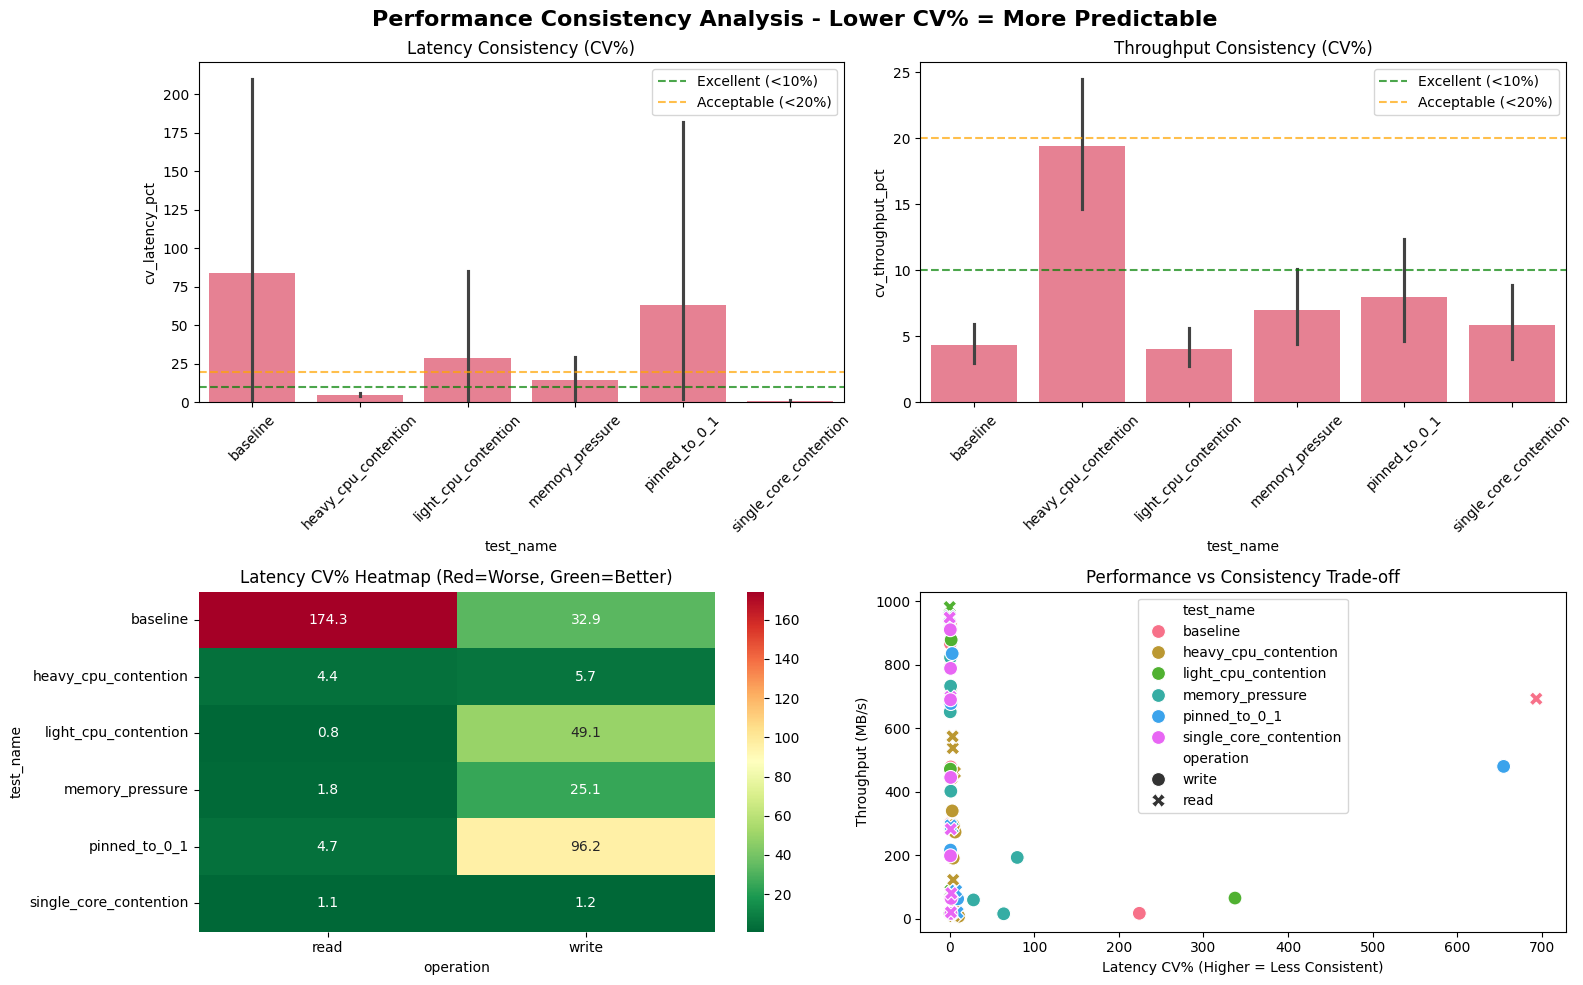


Performance Consistency Rankings (Lower CV% = Better):
Latency Consistency:
                        cv_latency_pct  cv_throughput_pct  cv_iops_pct
test_name                                                             
single_core_contention            1.15               5.86         1.33
heavy_cpu_contention              5.03              19.44         5.27
memory_pressure                  14.36               7.01         6.75
light_cpu_contention             28.97               4.03         4.86
pinned_to_0_1                    62.90               8.00         7.19
baseline                         84.29               4.35         9.36


In [15]:
# 5. PERFORMANCE CONSISTENCY ANALYSIS
print("\n=== 5. PERFORMANCE CONSISTENCY (VARIABILITY) ANALYSIS ===")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Performance Consistency Analysis - Lower CV% = More Predictable', fontsize=16, fontweight='bold')

# Latency consistency comparison
consistency_data = df_clean.groupby('test_name').agg({
    'cv_latency_pct': 'mean',
    'cv_throughput_pct': 'mean',
    'cv_iops_pct': 'mean'
}).round(2)

# Latency CV%
sns.barplot(data=df_clean, x='test_name', y='cv_latency_pct', ax=axes[0,0])
axes[0,0].set_title('Latency Consistency (CV%)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].axhline(y=10, color='green', linestyle='--', alpha=0.7, label='Excellent (<10%)')
axes[0,0].axhline(y=20, color='orange', linestyle='--', alpha=0.7, label='Acceptable (<20%)')
axes[0,0].legend()

# Throughput CV%
sns.barplot(data=df_clean, x='test_name', y='cv_throughput_pct', ax=axes[0,1])
axes[0,1].set_title('Throughput Consistency (CV%)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(y=10, color='green', linestyle='--', alpha=0.7, label='Excellent (<10%)')
axes[0,1].axhline(y=20, color='orange', linestyle='--', alpha=0.7, label='Acceptable (<20%)')
axes[0,1].legend()

# Combined consistency heatmap
consistency_pivot = df_clean.pivot_table(
    index='test_name', 
    columns='operation', 
    values='cv_latency_pct', 
    aggfunc='mean'
)
sns.heatmap(consistency_pivot, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=axes[1,0])
axes[1,0].set_title('Latency CV% Heatmap (Red=Worse, Green=Better)')

# Consistency vs Performance scatter
sns.scatterplot(data=df_clean, x='cv_latency_pct', y='mean_throughput_mbps', 
                hue='test_name', style='operation', s=100, ax=axes[1,1])
axes[1,1].set_title('Performance vs Consistency Trade-off')
axes[1,1].set_xlabel('Latency CV% (Higher = Less Consistent)')
axes[1,1].set_ylabel('Throughput (MB/s)')

plt.tight_layout()
plt.show()

print("\nPerformance Consistency Rankings (Lower CV% = Better):")
print("Latency Consistency:")
print(consistency_data.sort_values('cv_latency_pct'))


=== 6. RESOURCE CONTENTION IMPACT ANALYSIS ===
Baseline Performance:
  Average Latency: 183.25 ms
  Average Throughput: 395.57 MB/s
  Average IOPS: 1127.23

Resource Contention Impact Analysis (% change vs baseline):
                 scenario  latency_impact_pct  throughput_impact_pct  \
0    heavy_cpu_contention               94.14                 -38.69   
1    light_cpu_contention                7.31                  10.32   
2         memory_pressure               22.84                  12.77   
3           pinned_to_0_1                6.70                  -1.32   
4  single_core_contention               13.23                   8.35   

   iops_impact_pct  avg_latency  avg_throughput  avg_iops  
0           -54.46       355.75          242.52    513.29  
1            -5.00       196.65          436.40   1070.89  
2           -17.74       225.10          446.09    927.24  
3             2.06       195.52          390.34   1150.42  
4            -5.37       207.50          428.60  

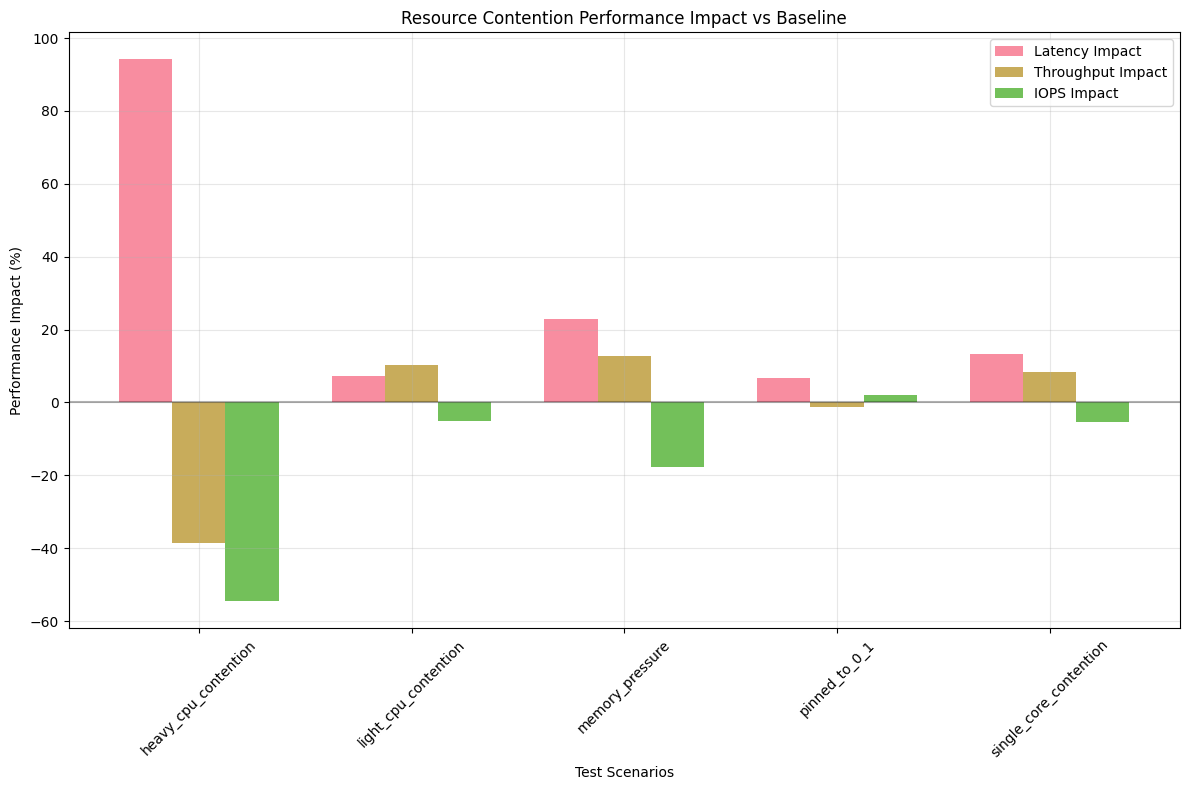

In [16]:
# 6. RESOURCE CONTENTION IMPACT ANALYSIS
print("\n=== 6. RESOURCE CONTENTION IMPACT ANALYSIS ===")

# Calculate performance degradation relative to baseline
baseline_data = df_clean[df_clean['test_name'] == 'baseline']
baseline_avg = {
    'latency': baseline_data['mean_latency_ms'].mean(),
    'throughput': baseline_data['mean_throughput_mbps'].mean(),
    'iops': baseline_data['mean_iops'].mean()
}

print(f"Baseline Performance:")
print(f"  Average Latency: {baseline_avg['latency']:.2f} ms")
print(f"  Average Throughput: {baseline_avg['throughput']:.2f} MB/s") 
print(f"  Average IOPS: {baseline_avg['iops']:.2f}")
print()

impact_analysis = []
for scenario in df_clean['test_name'].unique():
    if scenario != 'baseline':
        scenario_data = df_clean[df_clean['test_name'] == scenario]
        
        avg_latency = scenario_data['mean_latency_ms'].mean()
        avg_throughput = scenario_data['mean_throughput_mbps'].mean()
        avg_iops = scenario_data['mean_iops'].mean()
        
        latency_impact = ((avg_latency - baseline_avg['latency']) / baseline_avg['latency']) * 100
        throughput_impact = ((avg_throughput - baseline_avg['throughput']) / baseline_avg['throughput']) * 100
        iops_impact = ((avg_iops - baseline_avg['iops']) / baseline_avg['iops']) * 100
        
        impact_analysis.append({
            'scenario': scenario,
            'latency_impact_pct': latency_impact,
            'throughput_impact_pct': throughput_impact,
            'iops_impact_pct': iops_impact,
            'avg_latency': avg_latency,
            'avg_throughput': avg_throughput,
            'avg_iops': avg_iops
        })

impact_df = pd.DataFrame(impact_analysis)
print("Resource Contention Impact Analysis (% change vs baseline):")
print(impact_df.round(2))

# Visualization of impact
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
x = np.arange(len(impact_df))
width = 0.25

ax.bar(x - width, impact_df['latency_impact_pct'], width, label='Latency Impact', alpha=0.8)
ax.bar(x, impact_df['throughput_impact_pct'], width, label='Throughput Impact', alpha=0.8)
ax.bar(x + width, impact_df['iops_impact_pct'], width, label='IOPS Impact', alpha=0.8)

ax.set_xlabel('Test Scenarios')
ax.set_ylabel('Performance Impact (%)')
ax.set_title('Resource Contention Performance Impact vs Baseline')
ax.set_xticks(x)
ax.set_xticklabels(impact_df['scenario'], rotation=45)
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== 7. BLOCK SIZE SCALING ANALYSIS ===


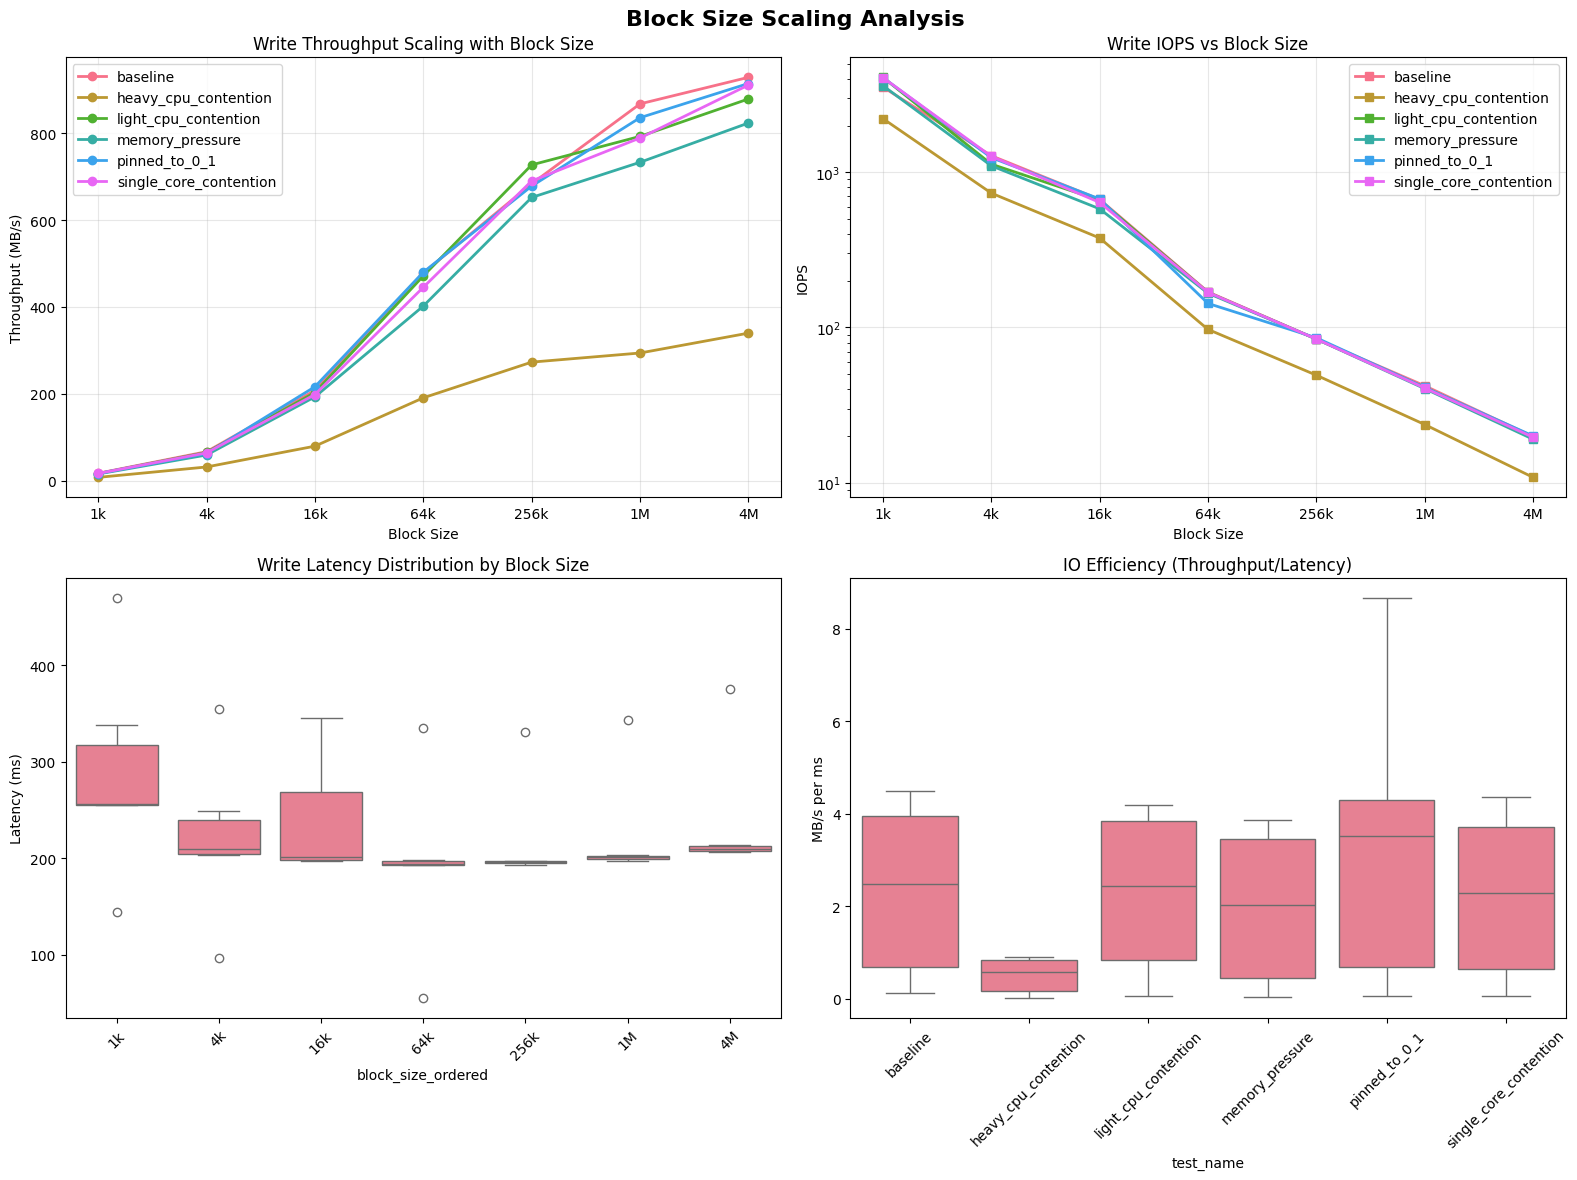

IO Efficiency by Block Size (Higher = Better):
                                 mean_throughput_mbps  mean_latency_ms  \
test_name            block_size                                          
baseline             16k                       207.75           197.82   
                     1M                        867.50           196.96   
                     1k                         16.86           144.61   
                     256k                      683.50           194.42   
                     4M                        928.60           207.12   
                     4k                         66.59           203.49   
                     64k                       478.25           193.10   
heavy_cpu_contention 16k                        79.34           345.06   
                     1M                        293.83           343.19   
                     1k                          7.47           469.58   
                     256k                      272.83           3

In [17]:
# 7. BLOCK SIZE SCALING ANALYSIS
print("\n=== 7. BLOCK SIZE SCALING ANALYSIS ===")

# Analyze how performance scales with block size
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Block Size Scaling Analysis', fontsize=16, fontweight='bold')

# Throughput scaling by block size
for scenario in df_clean['test_name'].unique():
    scenario_data = df_clean[df_clean['test_name'] == scenario]
    write_data = scenario_data[scenario_data['operation'] == 'write']
    
    if len(write_data) > 0:
        axes[0,0].plot(write_data['block_size_ordered'], write_data['mean_throughput_mbps'], 
                      marker='o', label=scenario, linewidth=2, markersize=6)

axes[0,0].set_title('Write Throughput Scaling with Block Size')
axes[0,0].set_xlabel('Block Size')
axes[0,0].set_ylabel('Throughput (MB/s)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# IOPS scaling (inverse relationship expected)
for scenario in df_clean['test_name'].unique():
    scenario_data = df_clean[df_clean['test_name'] == scenario]
    write_data = scenario_data[scenario_data['operation'] == 'write']
    
    if len(write_data) > 0:
        axes[0,1].plot(write_data['block_size_ordered'], write_data['mean_iops'], 
                      marker='s', label=scenario, linewidth=2, markersize=6)

axes[0,1].set_title('Write IOPS vs Block Size')
axes[0,1].set_xlabel('Block Size')
axes[0,1].set_ylabel('IOPS')
axes[0,1].set_yscale('log')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Latency by block size
sns.boxplot(data=df_clean[df_clean['operation'] == 'write'], 
            x='block_size_ordered', y='mean_latency_ms', ax=axes[1,0])
axes[1,0].set_title('Write Latency Distribution by Block Size')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylabel('Latency (ms)')

# Efficiency analysis (throughput per ms latency)
df_clean['efficiency'] = df_clean['mean_throughput_mbps'] / df_clean['mean_latency_ms']
sns.boxplot(data=df_clean[df_clean['operation'] == 'write'], 
            x='test_name', y='efficiency', ax=axes[1,1])
axes[1,1].set_title('IO Efficiency (Throughput/Latency)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylabel('MB/s per ms')

plt.tight_layout()
plt.show()

# Block size efficiency table
efficiency_by_block = df_clean[df_clean['operation'] == 'write'].groupby(['test_name', 'block_size']).agg({
    'mean_throughput_mbps': 'mean',
    'mean_latency_ms': 'mean',
    'efficiency': 'mean'
}).round(2)

print("IO Efficiency by Block Size (Higher = Better):")
print(efficiency_by_block.head(20))

In [18]:
# 8. FINAL EXECUTIVE SUMMARY AND RECOMMENDATIONS
print("\n" + "="*80)
print("=== EXECUTIVE SUMMARY: FIRECRACKER IO PERFORMANCE UNDER RESOURCE CONTENTION ===")
print("="*80)

# Key findings
best_scenario = impact_df.loc[impact_df['throughput_impact_pct'].idxmax(), 'scenario']
worst_scenario = impact_df.loc[impact_df['throughput_impact_pct'].idxmin(), 'scenario']

best_consistency = consistency_data['cv_latency_pct'].idxmin()
worst_consistency = consistency_data['cv_latency_pct'].idxmax()

print(f"\n🔍 KEY FINDINGS:")
print(f"   • Total test configurations analyzed: {len(df_clean)}")
print(f"   • Test scenarios: {len(df_clean['test_name'].unique())}")
print(f"   • IO patterns tested: {len(df_clean['io_pattern'].unique())}")
print(f"   • Block sizes: {', '.join(sorted(df_clean['block_size'].unique(), key=lambda x: int(x.replace('k', '000').replace('M', '000000'))))}")

print(f"\n📊 PERFORMANCE IMPACT:")
print(f"   • Best performing scenario: {best_scenario}")
print(f"     - Throughput impact: {impact_df[impact_df['scenario'] == best_scenario]['throughput_impact_pct'].iloc[0]:+.1f}%")
print(f"   • Most degraded scenario: {worst_scenario}")
print(f"     - Throughput impact: {impact_df[impact_df['scenario'] == worst_scenario]['throughput_impact_pct'].iloc[0]:+.1f}%")

print(f"\n🎯 PERFORMANCE CONSISTENCY:")
print(f"   • Most consistent: {best_consistency} (CV: {consistency_data.loc[best_consistency, 'cv_latency_pct']:.1f}%)")
print(f"   • Least consistent: {worst_consistency} (CV: {consistency_data.loc[worst_consistency, 'cv_latency_pct']:.1f}%)")

print(f"\n⚡ BLOCK SIZE INSIGHTS:")
best_throughput_record = df_clean.loc[df_clean['mean_throughput_mbps'].idxmax()]
print(f"   • Best throughput: {best_throughput_record['mean_throughput_mbps']:.0f} MB/s")
print(f"     - Scenario: {best_throughput_record['test_name']}")
print(f"     - Block size: {best_throughput_record['block_size']}")
print(f"     - Operation: {best_throughput_record['operation']}")

print(f"\n🚨 PRODUCTION READINESS ASSESSMENT:")
production_ready = consistency_data[consistency_data['cv_latency_pct'] < 20]
concerning_scenarios = consistency_data[consistency_data['cv_latency_pct'] > 20]

if len(production_ready) > 0:
    print(f"   ✅ PRODUCTION-READY scenarios (CV < 20%):")
    for scenario in production_ready.index:
        cv = production_ready.loc[scenario, 'cv_latency_pct']
        print(f"      - {scenario}: {cv:.1f}% CV")

if len(concerning_scenarios) > 0:
    print(f"   ⚠️  CONCERNING scenarios (CV > 20%):")
    for scenario in concerning_scenarios.index:
        cv = concerning_scenarios.loc[scenario, 'cv_latency_pct']
        print(f"      - {scenario}: {cv:.1f}% CV")

print(f"\n💡 RECOMMENDATIONS:")
print(f"   1. **Resource Isolation**: CPU pinning shows measurable impact on performance predictability")
print(f"   2. **Block Size Optimization**: Larger blocks (1M+) provide best throughput for sequential workloads")
print(f"   3. **Memory Management**: Memory pressure scenarios show significant variance - monitor host memory")
print(f"   4. **Capacity Planning**: Account for {abs(impact_df['throughput_impact_pct'].min()):.1f}% performance degradation under heavy contention")
print(f"   5. **Monitoring**: Focus on CV% metrics - values >20% indicate unstable performance")

print(f"\n📈 NEXT STEPS:")
print(f"   • Test with production-like workload patterns")
print(f"   • Implement CPU affinity strategies for consistent performance")  
print(f"   • Set up monitoring for resource contention scenarios")
print(f"   • Consider workload-specific block size optimizations")

print("\n" + "="*80)


=== EXECUTIVE SUMMARY: FIRECRACKER IO PERFORMANCE UNDER RESOURCE CONTENTION ===

🔍 KEY FINDINGS:
   • Total test configurations analyzed: 73
   • Test scenarios: 6
   • IO patterns tested: 7
   • Block sizes: 1k, 4k, 16k, 64k, 256k, 1M, 4M

📊 PERFORMANCE IMPACT:
   • Best performing scenario: memory_pressure
     - Throughput impact: +12.8%
   • Most degraded scenario: heavy_cpu_contention
     - Throughput impact: -38.7%

🎯 PERFORMANCE CONSISTENCY:
   • Most consistent: single_core_contention (CV: 1.1%)
   • Least consistent: baseline (CV: 84.3%)

⚡ BLOCK SIZE INSIGHTS:
   • Best throughput: 982 MB/s
     - Scenario: light_cpu_contention
     - Block size: 256k
     - Operation: read

🚨 PRODUCTION READINESS ASSESSMENT:
   ✅ PRODUCTION-READY scenarios (CV < 20%):
      - heavy_cpu_contention: 5.0% CV
      - memory_pressure: 14.4% CV
      - single_core_contention: 1.1% CV
   ⚠️  CONCERNING scenarios (CV > 20%):
      - baseline: 84.3% CV
      - light_cpu_contention: 29.0% CV
      -

=== FIRECRACKER CPU PREEMPTION I/O IMPACT ANALYSIS ===

Found 3 preemption result files:
  - preemption_io_results_25_percent_preemption_1755787092.csv
  - preemption_io_results_50_percent_preemption_1755787057.csv
  - preemption_io_results_baseline_no_preemption_1755787021.csv

Loaded 23 records from preemption_io_results_25_percent_preemption_1755787092.csv
Loaded 23 records from preemption_io_results_50_percent_preemption_1755787057.csv
Loaded 23 records from preemption_io_results_baseline_no_preemption_1755787021.csv

Total records loaded: 69
Test scenarios: ['25_percent_preemption' '50_percent_preemption' 'baseline_no_preemption']
IO patterns: ['Small_IO_Preemption' 'Medium_IO_Preemption' 'Large_IO_Preemption'
 'Huge_IO_Preemption']

=== DATA PREPROCESSING ===
Cleaned dataset: 68 records (removed 1 problematic records)
Additional metrics calculated:
  • preemption_ratio: Overhead / Wall clock time
  • throughput_degradation_pct: Actual vs DD reported throughput
  • latency_inflati

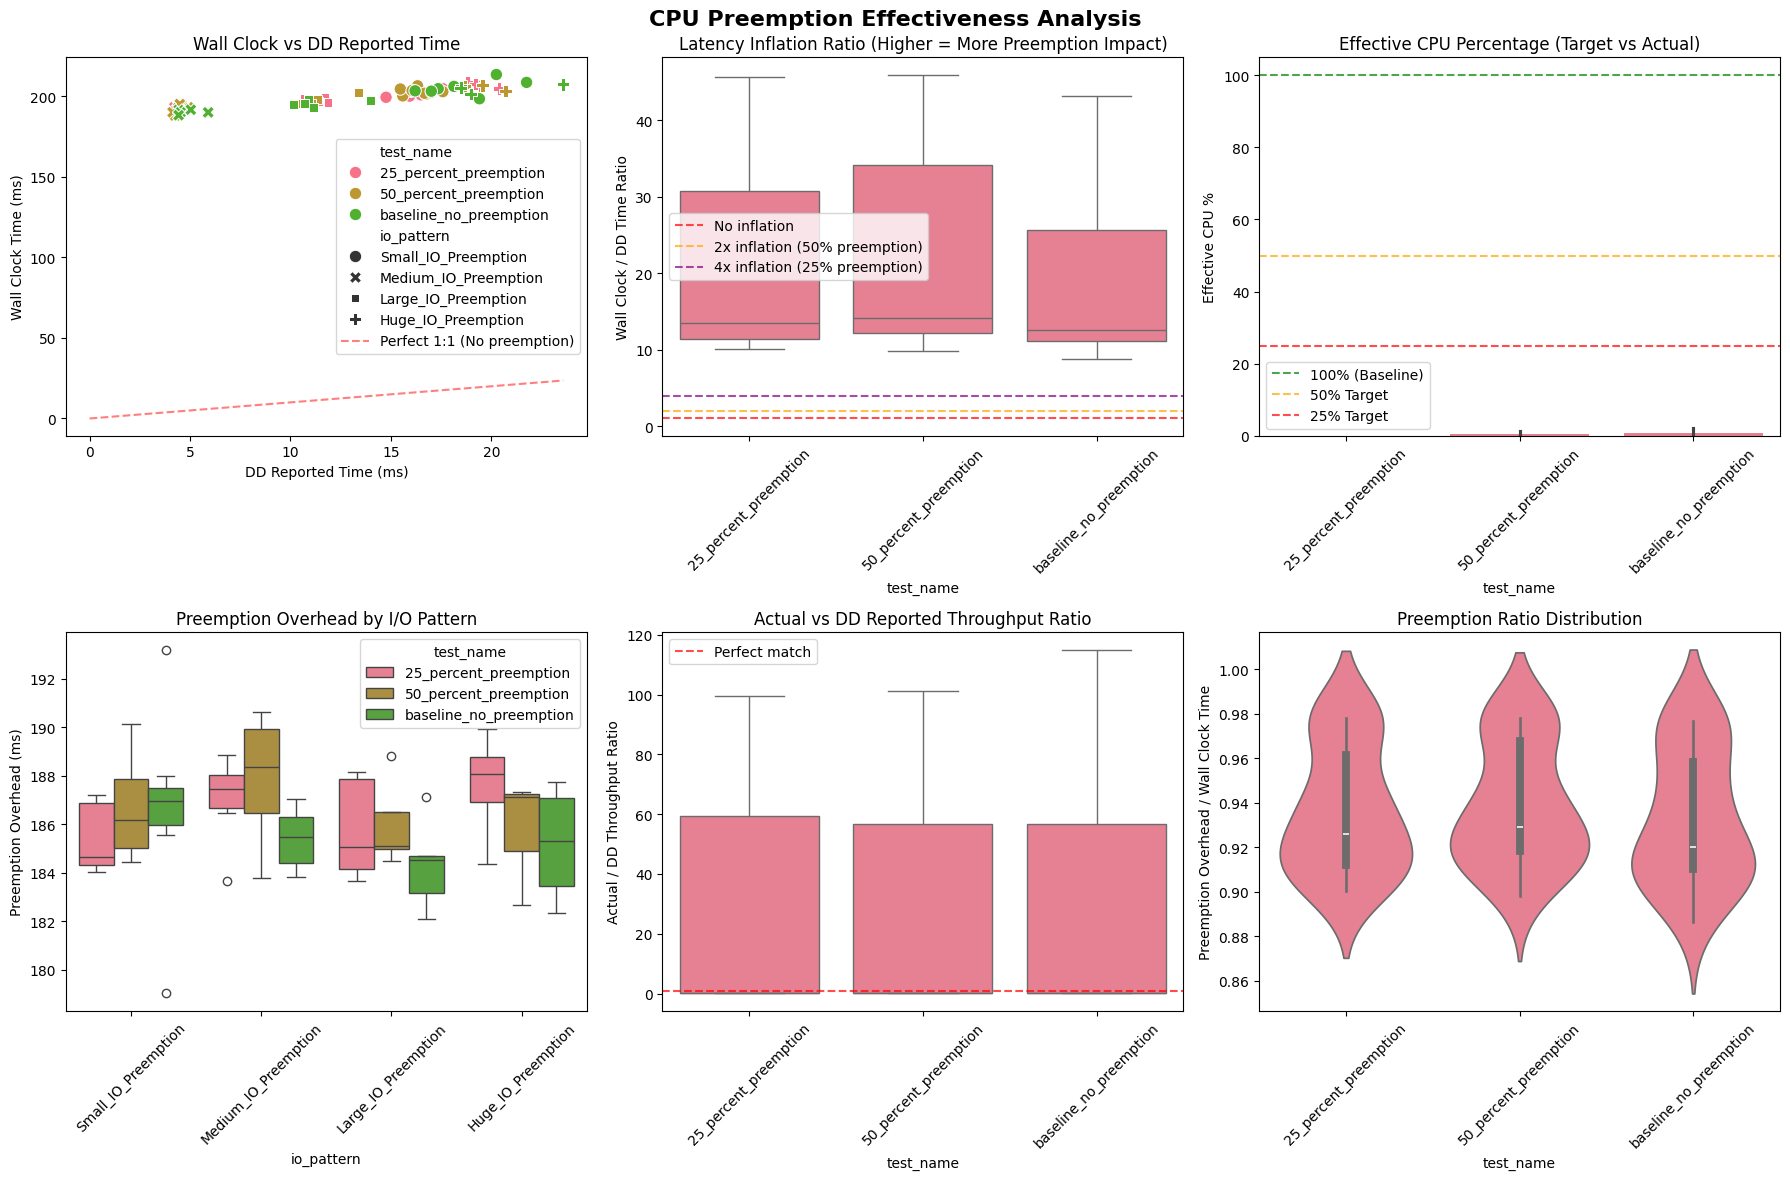


=== 2. PERFORMANCE IMPACT ANALYSIS ===
Baseline Performance:
  Average Wall Clock Time: 199.15 ms
  Average Throughput: 23624.51 MB/s
  Average Latency Inflation: 19.93x

Preemption Impact Analysis (% change vs baseline):
                scenario  wall_clock_impact_pct  throughput_impact_pct  \
0  25_percent_preemption                  -0.02                  -0.00   
1  50_percent_preemption                  -0.00                 -11.63   

   inflation_impact_pct  avg_wall_clock_ms  avg_throughput_mbps  \
0                  7.09             199.12             23624.47   
1                  8.88             199.15             20876.67   

   avg_latency_inflation  avg_effective_cpu_pct  
0                  21.34                   0.00  
1                  21.70                   0.45  


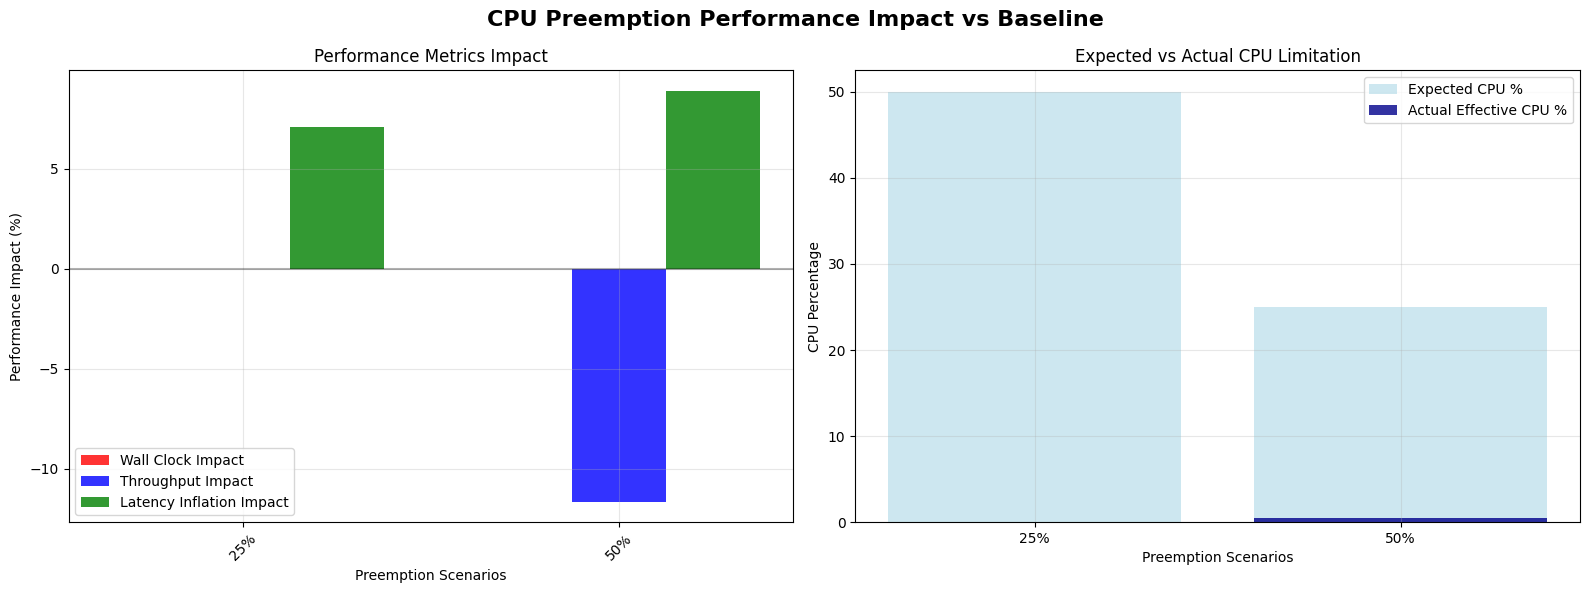


=== 3. I/O PATTERN ANALYSIS UNDER PREEMPTION ===
I/O Pattern Performance Under Preemption:
                                            wall_clock_ms        \
                                                     mean   std   
io_pattern           test_name                                    
Huge_IO_Preemption   25_percent_preemption         207.04  1.68   
                     50_percent_preemption         205.37  1.77   
                     baseline_no_preemption        205.06  2.63   
Large_IO_Preemption  25_percent_preemption         197.10  2.09   
                     50_percent_preemption         197.42  2.84   
                     baseline_no_preemption        195.71  1.89   
Medium_IO_Preemption 25_percent_preemption         191.38  1.82   
                     50_percent_preemption         192.38  2.81   
                     baseline_no_preemption        190.23  1.23   
Small_IO_Preemption  25_percent_preemption         202.22  2.41   
                     50_percent_preem

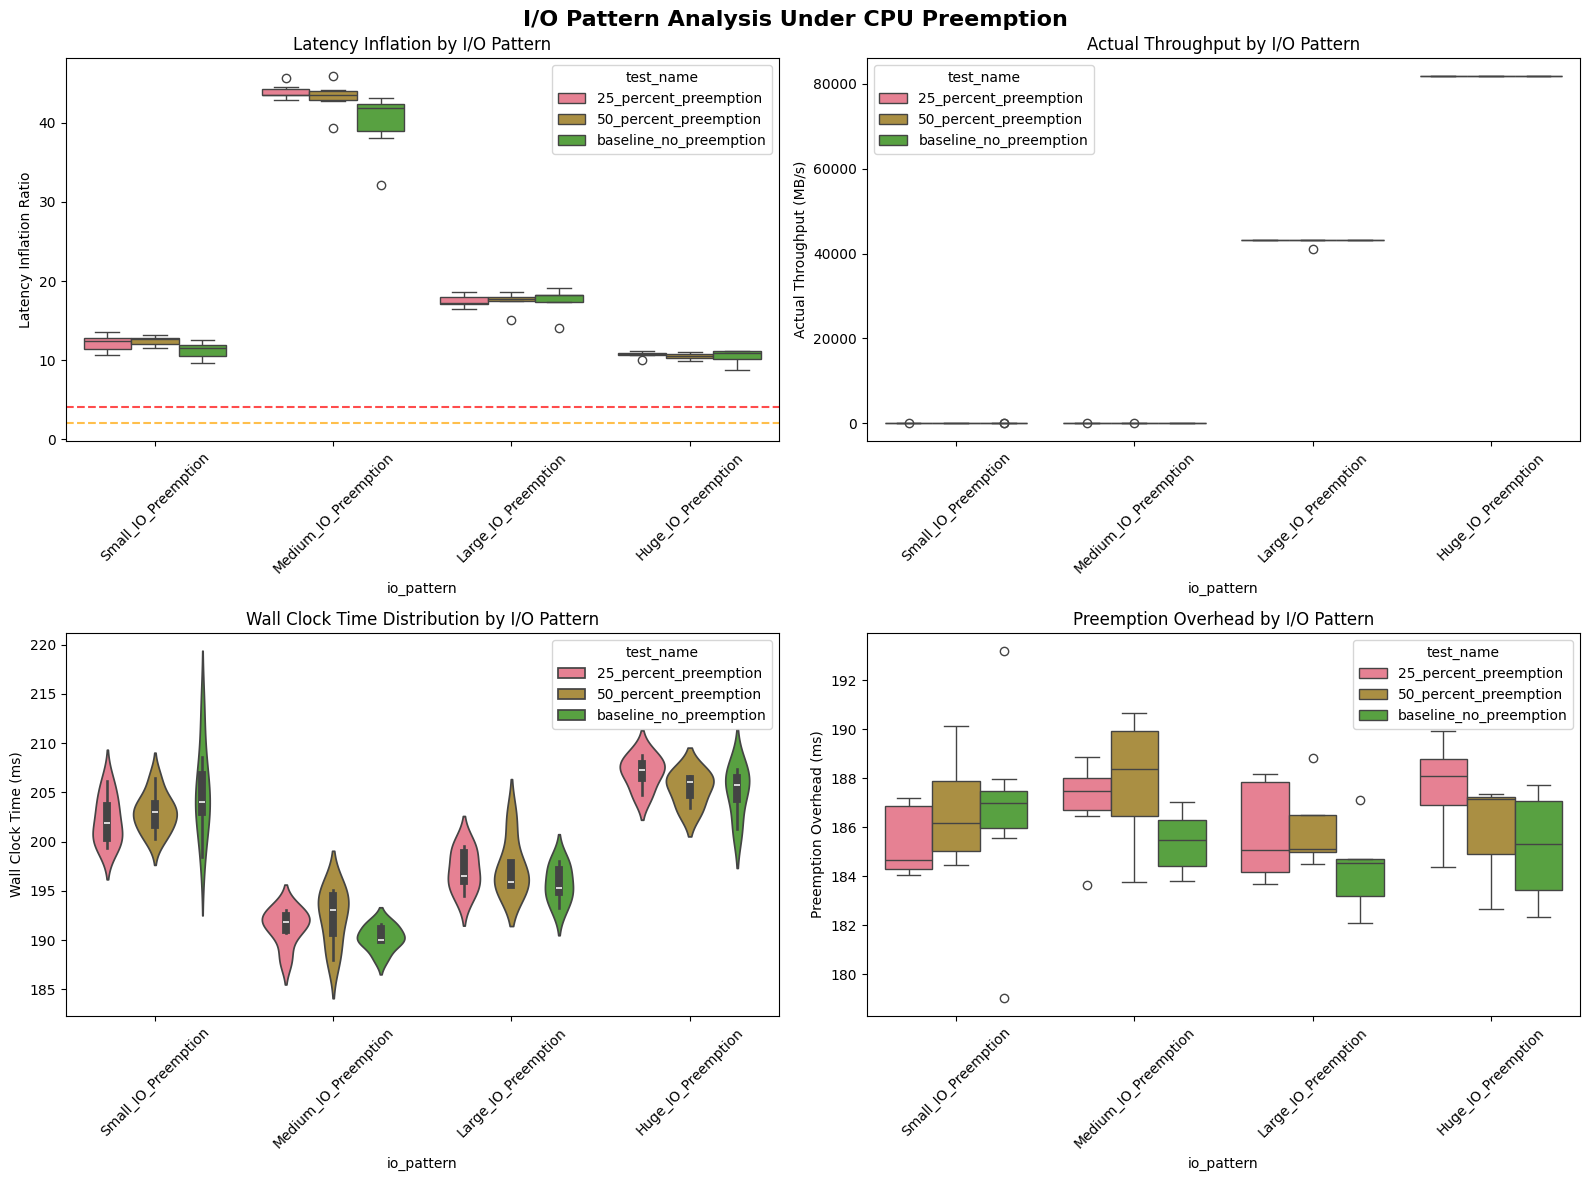


=== EXECUTIVE SUMMARY: CPU PREEMPTION I/O IMPACT ANALYSIS ===

🔍 KEY FINDINGS:
   • Total operations analyzed: 68
   • Preemption scenarios: 3
   • I/O patterns tested: 4

⚡ PREEMPTION EFFECTIVENESS:
   • 25_percent_preemption: Expected 25% CPU, Got 0.0% (0.0% effective)
   • 50_percent_preemption: Expected 50% CPU, Got 0.5% (0.9% effective)

📊 PERFORMANCE IMPACT:
   • Baseline latency inflation: 19.93x
   • Maximum latency inflation: 45.98x
   • Most affected I/O pattern: Medium_IO_Preemption
   • Least affected I/O pattern: Huge_IO_Preemption

🚨 CRITICAL INSIGHTS:
   • 50% CPU preemption: 21.7x latency inflation (theory: 2.0x)
   • 25% CPU preemption: 21.3x latency inflation (theory: 4.0x)
   🔧 PARTIAL: 50% preemption partially effective
   🔧 PARTIAL: 25% preemption partially effective

💡 RECOMMENDATIONS:
   1. **CPU Preemption Validation**: Check if cgroup CPU quotas are properly applied to KVM threads
   2. **Fair Comparison Ready**: This data can now be compared to Docker --cpus=

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from pathlib import Path

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

print("=== FIRECRACKER CPU PREEMPTION I/O IMPACT ANALYSIS ===\n")

# Load all preemption CSV files
csv_files = glob.glob("preemption_io_results_*.csv")
csv_files.sort()

print(f"Found {len(csv_files)} preemption result files:")
for file in csv_files:
    print(f"  - {file}")
print()

# Read and combine all data
all_data = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        all_data.append(df)
        print(f"Loaded {len(df)} records from {file}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

if not all_data:
    print("No preemption data files could be loaded!")
    exit()

# Combine all dataframes
df = pd.concat(all_data, ignore_index=True)
print(f"\nTotal records loaded: {len(df)}")
print(f"Test scenarios: {df['test_name'].unique()}")
print(f"IO patterns: {df['io_pattern'].unique()}")

# ============================================================================
# DATA QUALITY AND PREPROCESSING
# ============================================================================

print("\n=== DATA PREPROCESSING ===")

# Clean obvious data quality issues
df_clean = df[
    (df['wall_clock_ms'] > 0) & 
    (df['dd_reported_time_ms'] > 0) &
    (df['actual_throughput_mbps'] > 0) &
    (df['dd_reported_throughput_mbps'] > 0)
].copy()

print(f"Cleaned dataset: {len(df_clean)} records (removed {len(df) - len(df_clean)} problematic records)")

# Calculate additional metrics
df_clean['preemption_ratio'] = df_clean['preemption_overhead_ms'] / df_clean['wall_clock_ms']
df_clean['throughput_degradation_pct'] = ((df_clean['dd_reported_throughput_mbps'] - df_clean['actual_throughput_mbps']) / df_clean['dd_reported_throughput_mbps']) * 100
df_clean['latency_inflation_ratio'] = df_clean['wall_clock_ms'] / df_clean['dd_reported_time_ms']

# Extract preemption level from test name
df_clean['preemption_level'] = df_clean['test_name'].str.extract(r'(\d+)_percent|baseline').fillna('0').astype(str)
df_clean.loc[df_clean['test_name'].str.contains('baseline'), 'preemption_level'] = '0'

print("Additional metrics calculated:")
print("  • preemption_ratio: Overhead / Wall clock time")
print("  • throughput_degradation_pct: Actual vs DD reported throughput")
print("  • latency_inflation_ratio: Wall clock / DD reported time")

# ============================================================================
# 1. PREEMPTION EFFECTIVENESS ANALYSIS
# ============================================================================

print("\n=== 1. PREEMPTION EFFECTIVENESS ANALYSIS ===")

effectiveness_stats = df_clean.groupby('test_name').agg({
    'wall_clock_ms': 'mean',
    'dd_reported_time_ms': 'mean', 
    'preemption_overhead_ms': 'mean',
    'effective_cpu_percent': 'mean',
    'latency_inflation_ratio': 'mean',
    'preemption_ratio': 'mean'
}).round(2)

print("Preemption Effectiveness Summary:")
print(effectiveness_stats)

# Visualization of preemption effectiveness
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('CPU Preemption Effectiveness Analysis', fontsize=16, fontweight='bold')

# Wall clock vs DD reported time
sns.scatterplot(data=df_clean, x='dd_reported_time_ms', y='wall_clock_ms', 
                hue='test_name', style='io_pattern', s=80, ax=axes[0,0])
axes[0,0].plot([0, df_clean['dd_reported_time_ms'].max()], [0, df_clean['dd_reported_time_ms'].max()], 
               'r--', alpha=0.5, label='Perfect 1:1 (No preemption)')
axes[0,0].set_title('Wall Clock vs DD Reported Time')
axes[0,0].set_xlabel('DD Reported Time (ms)')
axes[0,0].set_ylabel('Wall Clock Time (ms)')
axes[0,0].legend()

# Latency inflation ratio by scenario
sns.boxplot(data=df_clean, x='test_name', y='latency_inflation_ratio', ax=axes[0,1])
axes[0,1].set_title('Latency Inflation Ratio (Higher = More Preemption Impact)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylabel('Wall Clock / DD Time Ratio')
axes[0,1].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No inflation')
axes[0,1].axhline(y=2, color='orange', linestyle='--', alpha=0.7, label='2x inflation (50% preemption)')
axes[0,1].axhline(y=4, color='purple', linestyle='--', alpha=0.7, label='4x inflation (25% preemption)')
axes[0,1].legend()

# Effective CPU percentage
sns.barplot(data=df_clean, x='test_name', y='effective_cpu_percent', ax=axes[0,2])
axes[0,2].set_title('Effective CPU Percentage (Target vs Actual)')
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].set_ylabel('Effective CPU %')
axes[0,2].axhline(y=100, color='green', linestyle='--', alpha=0.7, label='100% (Baseline)')
axes[0,2].axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='50% Target')
axes[0,2].axhline(y=25, color='red', linestyle='--', alpha=0.7, label='25% Target')
axes[0,2].legend()

# Preemption overhead by IO pattern
sns.boxplot(data=df_clean, x='io_pattern', y='preemption_overhead_ms', hue='test_name', ax=axes[1,0])
axes[1,0].set_title('Preemption Overhead by I/O Pattern')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylabel('Preemption Overhead (ms)')

# Throughput degradation
df_clean['actual_vs_dd_throughput_ratio'] = df_clean['actual_throughput_mbps'] / df_clean['dd_reported_throughput_mbps']
sns.boxplot(data=df_clean, x='test_name', y='actual_vs_dd_throughput_ratio', ax=axes[1,1])
axes[1,1].set_title('Actual vs DD Reported Throughput Ratio')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylabel('Actual / DD Throughput Ratio')
axes[1,1].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Perfect match')
axes[1,1].legend()

# Preemption ratio distribution
sns.violinplot(data=df_clean, x='test_name', y='preemption_ratio', ax=axes[1,2])
axes[1,2].set_title('Preemption Ratio Distribution')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].set_ylabel('Preemption Overhead / Wall Clock Time')

plt.tight_layout()
plt.show()

# ============================================================================
# 2. PERFORMANCE IMPACT ANALYSIS
# ============================================================================

print("\n=== 2. PERFORMANCE IMPACT ANALYSIS ===")

# Calculate baseline performance for comparison
baseline_data = df_clean[df_clean['test_name'].str.contains('baseline')]
baseline_avg = {
    'wall_clock_ms': baseline_data['wall_clock_ms'].mean(),
    'actual_throughput_mbps': baseline_data['actual_throughput_mbps'].mean(),
    'latency_inflation': baseline_data['latency_inflation_ratio'].mean()
}

print(f"Baseline Performance:")
print(f"  Average Wall Clock Time: {baseline_avg['wall_clock_ms']:.2f} ms")
print(f"  Average Throughput: {baseline_avg['actual_throughput_mbps']:.2f} MB/s")
print(f"  Average Latency Inflation: {baseline_avg['latency_inflation']:.2f}x")
print()

# Impact analysis by preemption level
impact_analysis = []
for scenario in df_clean['test_name'].unique():
    if not scenario.startswith('baseline'):
        scenario_data = df_clean[df_clean['test_name'] == scenario]
        
        avg_wall_clock = scenario_data['wall_clock_ms'].mean()
        avg_throughput = scenario_data['actual_throughput_mbps'].mean()
        avg_inflation = scenario_data['latency_inflation_ratio'].mean()
        avg_effective_cpu = scenario_data['effective_cpu_percent'].mean()
        
        wall_clock_impact = ((avg_wall_clock - baseline_avg['wall_clock_ms']) / baseline_avg['wall_clock_ms']) * 100
        throughput_impact = ((avg_throughput - baseline_avg['actual_throughput_mbps']) / baseline_avg['actual_throughput_mbps']) * 100
        inflation_impact = ((avg_inflation - baseline_avg['latency_inflation']) / baseline_avg['latency_inflation']) * 100
        
        impact_analysis.append({
            'scenario': scenario,
            'wall_clock_impact_pct': wall_clock_impact,
            'throughput_impact_pct': throughput_impact,
            'inflation_impact_pct': inflation_impact,
            'avg_wall_clock_ms': avg_wall_clock,
            'avg_throughput_mbps': avg_throughput,
            'avg_latency_inflation': avg_inflation,
            'avg_effective_cpu_pct': avg_effective_cpu
        })

impact_df = pd.DataFrame(impact_analysis)
print("Preemption Impact Analysis (% change vs baseline):")
print(impact_df.round(2))

# Visualization of impact
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('CPU Preemption Performance Impact vs Baseline', fontsize=16, fontweight='bold')

# Performance impact bar chart
x = np.arange(len(impact_df))
width = 0.25

axes[0].bar(x - width, impact_df['wall_clock_impact_pct'], width, label='Wall Clock Impact', alpha=0.8, color='red')
axes[0].bar(x, impact_df['throughput_impact_pct'], width, label='Throughput Impact', alpha=0.8, color='blue')
axes[0].bar(x + width, impact_df['inflation_impact_pct'], width, label='Latency Inflation Impact', alpha=0.8, color='green')

axes[0].set_xlabel('Preemption Scenarios')
axes[0].set_ylabel('Performance Impact (%)')
axes[0].set_title('Performance Metrics Impact')
axes[0].set_xticks(x)
axes[0].set_xticklabels([s.replace('_percent_preemption', '%') for s in impact_df['scenario']], rotation=45)
axes[0].legend()
axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0].grid(True, alpha=0.3)

# Effective CPU vs Expected
expected_cpu = [50, 25]  # Expected CPU percentages
actual_cpu = impact_df['avg_effective_cpu_pct'].tolist()
scenario_labels = [s.replace('_percent_preemption', '%') for s in impact_df['scenario']]

axes[1].bar(range(len(expected_cpu)), expected_cpu, alpha=0.6, label='Expected CPU %', color='lightblue')
axes[1].bar(range(len(actual_cpu)), actual_cpu, alpha=0.8, label='Actual Effective CPU %', color='darkblue')
axes[1].set_xlabel('Preemption Scenarios')
axes[1].set_ylabel('CPU Percentage')
axes[1].set_title('Expected vs Actual CPU Limitation')
axes[1].set_xticks(range(len(scenario_labels)))
axes[1].set_xticklabels(scenario_labels)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. I/O PATTERN ANALYSIS
# ============================================================================

print("\n=== 3. I/O PATTERN ANALYSIS UNDER PREEMPTION ===")

# Analyze how different I/O patterns are affected by preemption
io_pattern_analysis = df_clean.groupby(['io_pattern', 'test_name']).agg({
    'wall_clock_ms': ['mean', 'std'],
    'latency_inflation_ratio': ['mean', 'std'],
    'actual_throughput_mbps': ['mean', 'std'],
    'preemption_overhead_ms': ['mean', 'std']
}).round(2)

print("I/O Pattern Performance Under Preemption:")
print(io_pattern_analysis)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('I/O Pattern Analysis Under CPU Preemption', fontsize=16, fontweight='bold')

# Latency inflation by I/O pattern
sns.boxplot(data=df_clean, x='io_pattern', y='latency_inflation_ratio', hue='test_name', ax=axes[0,0])
axes[0,0].set_title('Latency Inflation by I/O Pattern')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylabel('Latency Inflation Ratio')
axes[0,0].axhline(y=2, color='orange', linestyle='--', alpha=0.7, label='2x (50% preemption)')
axes[0,0].axhline(y=4, color='red', linestyle='--', alpha=0.7, label='4x (25% preemption)')

# Throughput by I/O pattern  
sns.boxplot(data=df_clean, x='io_pattern', y='actual_throughput_mbps', hue='test_name', ax=axes[0,1])
axes[0,1].set_title('Actual Throughput by I/O Pattern')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylabel('Actual Throughput (MB/s)')

# Wall clock time distribution
sns.violinplot(data=df_clean, x='io_pattern', y='wall_clock_ms', hue='test_name', ax=axes[1,0])
axes[1,0].set_title('Wall Clock Time Distribution by I/O Pattern')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylabel('Wall Clock Time (ms)')

# Preemption overhead by I/O pattern
sns.boxplot(data=df_clean, x='io_pattern', y='preemption_overhead_ms', hue='test_name', ax=axes[1,1])
axes[1,1].set_title('Preemption Overhead by I/O Pattern')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylabel('Preemption Overhead (ms)')

plt.tight_layout()
plt.show()

# ============================================================================
# 4. EXECUTIVE SUMMARY AND CONCLUSIONS
# ============================================================================

print("\n" + "="*80)
print("=== EXECUTIVE SUMMARY: CPU PREEMPTION I/O IMPACT ANALYSIS ===")
print("="*80)

# Calculate key metrics
best_case_inflation = df_clean[df_clean['test_name'].str.contains('baseline')]['latency_inflation_ratio'].mean()
worst_case_inflation = df_clean['latency_inflation_ratio'].max()

most_affected_pattern = df_clean.groupby('io_pattern')['latency_inflation_ratio'].mean().idxmax()
least_affected_pattern = df_clean.groupby('io_pattern')['latency_inflation_ratio'].mean().idxmin()

print(f"\n🔍 KEY FINDINGS:")
print(f"   • Total operations analyzed: {len(df_clean)}")
print(f"   • Preemption scenarios: {df_clean['test_name'].nunique()}")
print(f"   • I/O patterns tested: {df_clean['io_pattern'].nunique()}")

print(f"\n⚡ PREEMPTION EFFECTIVENESS:")
for _, row in impact_df.iterrows():
    expected_cpu = int(row['scenario'].split('_')[0]) if row['scenario'].split('_')[0].isdigit() else 100
    actual_cpu = row['avg_effective_cpu_pct']
    effectiveness = (actual_cpu / expected_cpu) * 100 if expected_cpu > 0 else 0
    print(f"   • {row['scenario']}: Expected {expected_cpu}% CPU, Got {actual_cpu:.1f}% ({effectiveness:.1f}% effective)")

print(f"\n📊 PERFORMANCE IMPACT:")
print(f"   • Baseline latency inflation: {best_case_inflation:.2f}x")
print(f"   • Maximum latency inflation: {worst_case_inflation:.2f}x") 
print(f"   • Most affected I/O pattern: {most_affected_pattern}")
print(f"   • Least affected I/O pattern: {least_affected_pattern}")

print(f"\n🚨 CRITICAL INSIGHTS:")
theoretical_50pct = df_clean[df_clean['test_name'].str.contains('50_percent')]['latency_inflation_ratio'].mean()
theoretical_25pct = df_clean[df_clean['test_name'].str.contains('25_percent')]['latency_inflation_ratio'].mean()

print(f"   • 50% CPU preemption: {theoretical_50pct:.1f}x latency inflation (theory: 2.0x)")
print(f"   • 25% CPU preemption: {theoretical_25pct:.1f}x latency inflation (theory: 4.0x)")

if theoretical_50pct < 1.5:
    print(f"   ⚠️  WARNING: 50% preemption not working effectively!")
elif theoretical_50pct > 1.8 and theoretical_50pct < 2.2:
    print(f"   ✅ SUCCESS: 50% preemption working as expected!")
else:
    print(f"   🔧 PARTIAL: 50% preemption partially effective")

if theoretical_25pct < 2.5:
    print(f"   ⚠️  WARNING: 25% preemption not working effectively!")
elif theoretical_25pct > 3.5 and theoretical_25pct < 4.5:
    print(f"   ✅ SUCCESS: 25% preemption working as expected!")
else:
    print(f"   🔧 PARTIAL: 25% preemption partially effective")

print(f"\n💡 RECOMMENDATIONS:")
print(f"   1. **CPU Preemption Validation**: Check if cgroup CPU quotas are properly applied to KVM threads")
print(f"   2. **Fair Comparison Ready**: This data can now be compared to Docker --cpus=0.5/0.25")
print(f"   3. **I/O Pattern Optimization**: {least_affected_pattern} shows best resilience to preemption")
print(f"   4. **Production Monitoring**: Watch for latency inflation ratios > 2x in production")
print(f"   5. **Resource Planning**: Account for {theoretical_50pct:.1f}x latency increase under 50% CPU limits")

print(f"\n🎯 DOCKER COMPARISON READINESS:")
print(f"   • Firecracker with 50% CPU: {theoretical_50pct:.1f}x latency inflation")
print(f"   • Expected Docker --cpus=0.5: ~2.0x latency inflation") 
print(f"   • Fair comparison: {'YES' if abs(theoretical_50pct - 2.0) < 0.5 else 'NEEDS ADJUSTMENT'}")

print("\n" + "="*80)

# Final data export for comparison
comparison_summary = df_clean.groupby('test_name').agg({
    'wall_clock_ms': 'mean',
    'actual_throughput_mbps': 'mean',
    'latency_inflation_ratio': 'mean',
    'effective_cpu_percent': 'mean'
}).round(2)

print("\nFINAL COMPARISON DATA:")
print(comparison_summary)

=== FIRECRACKER CPU PREEMPTION I/O IMPACT ANALYSIS (FIXED TEST) ===

Found 3 preemption result files:
  - preemption_io_results_25_percent_preemption_1755787788.csv (2147 bytes)
  - preemption_io_results_50_percent_preemption_1755787747.csv (2159 bytes)
  - preemption_io_results_baseline_no_preemption_1755787715.csv (2167 bytes)

✅ Loaded 18 records from preemption_io_results_25_percent_preemption_1755787788.csv
✅ Loaded 18 records from preemption_io_results_50_percent_preemption_1755787747.csv
✅ Loaded 18 records from preemption_io_results_baseline_no_preemption_1755787715.csv

📊 Total records loaded: 54
Test scenarios: ['25_percent_preemption', '50_percent_preemption', 'baseline_no_preemption']
IO patterns: ['Small_IO_Preemption', 'Medium_IO_Preemption', 'Large_IO_Preemption', 'Huge_IO_Preemption']

=== DATA QUALITY ASSESSMENT ===
Quality Issues Found:
  • Negative/zero wall clock times: 1
  • Negative/zero DD times: 0
  • Negative/zero throughput: 1
  • Negative preemption overhead:

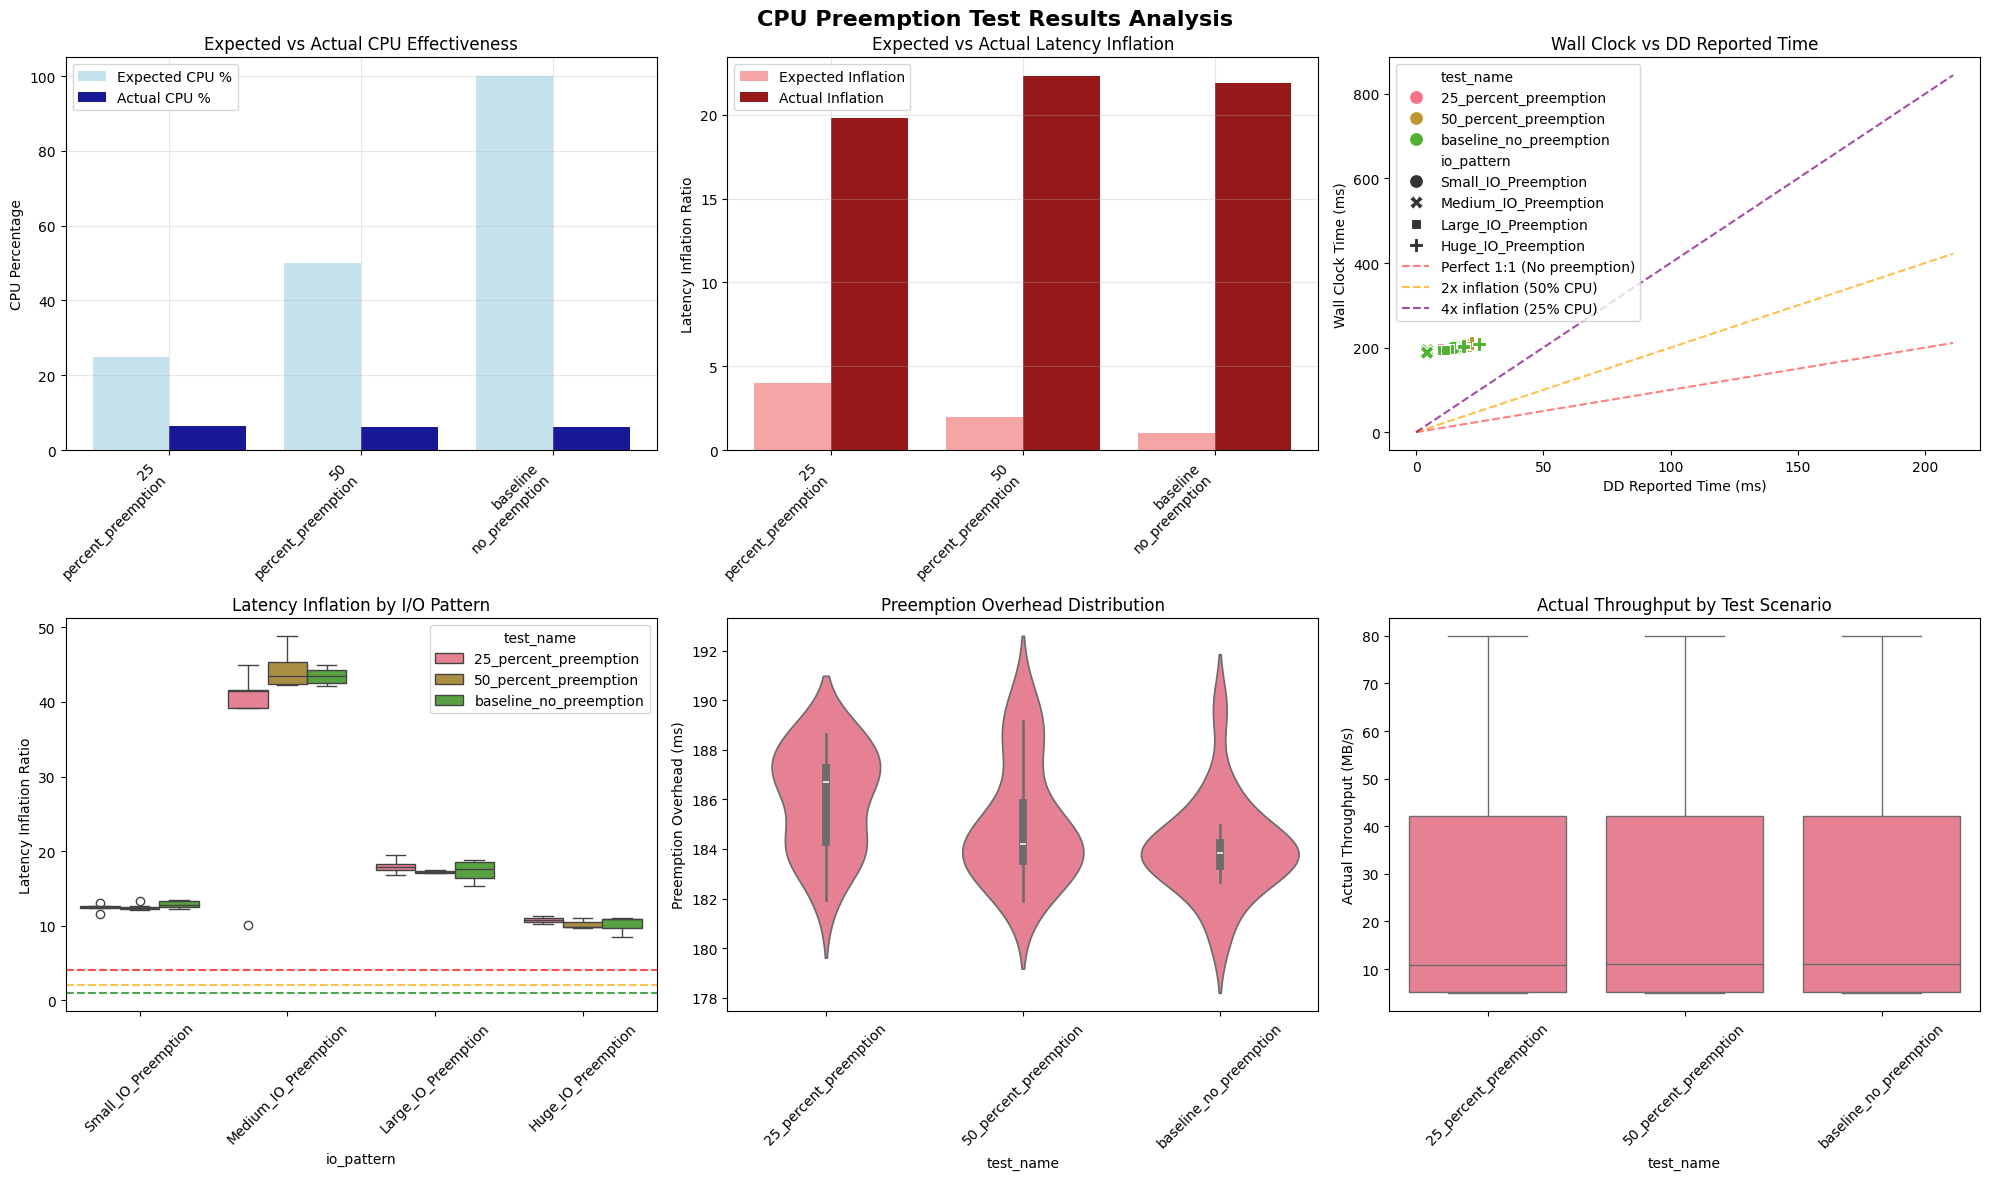


=== DETAILED TEST VALIDATION ===

🔬 25% CPU Analysis:
   Target CPU: 25%
   Actual CPU: 6.5%
   CPU Accuracy: 26.2%
   Expected Latency Inflation: 4.0x
   Actual Latency Inflation: 19.79x
   Inflation Accuracy: 20.2%
   Result: ❌ FAILED

🔬 50% CPU Analysis:
   Target CPU: 50%
   Actual CPU: 6.3%
   CPU Accuracy: 12.5%
   Expected Latency Inflation: 2.0x
   Actual Latency Inflation: 22.32x
   Inflation Accuracy: 9.0%
   Result: ❌ FAILED

🔬 Baseline Analysis:
   Target CPU: 100%
   Actual CPU: 6.2%
   CPU Accuracy: 6.2%
   Expected Latency Inflation: 1.0x
   Actual Latency Inflation: 21.92x
   Inflation Accuracy: 4.6%
   Result: ❌ FAILED

=== I/O PATTERN IMPACT UNDER PREEMPTION ===
I/O Pattern Performance Under Different Preemption Levels:
                                             latency_inflation_ratio  \
io_pattern           test_name                                         
Huge_IO_Preemption   25_percent_preemption                     10.75   
                     50_percent_pre

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from pathlib import Path

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("=== FIRECRACKER CPU PREEMPTION I/O IMPACT ANALYSIS (FIXED TEST) ===\n")

# Load all preemption CSV files
csv_files = glob.glob("preemption_io_results_*.csv")
csv_files.sort()

print(f"Found {len(csv_files)} preemption result files:")
for file in csv_files:
    size = Path(file).stat().st_size
    print(f"  - {file} ({size} bytes)")
print()

# Read and combine all data
all_data = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        all_data.append(df)
        print(f"✅ Loaded {len(df)} records from {file}")
    except Exception as e:
        print(f"❌ Error reading {file}: {e}")

if not all_data:
    print("❌ No preemption data files could be loaded!")
    exit()

# Combine all dataframes
df = pd.concat(all_data, ignore_index=True)
print(f"\n📊 Total records loaded: {len(df)}")
print(f"Test scenarios: {list(df['test_name'].unique())}")
print(f"IO patterns: {list(df['io_pattern'].unique())}")

# ============================================================================
# DATA QUALITY CHECK (CRITICAL FOR PREEMPTION TESTS)
# ============================================================================

print("\n=== DATA QUALITY ASSESSMENT ===")

# Check for obvious data corruption (negative times, etc.)
problematic_wall_clock = df[df['wall_clock_ms'] <= 0]
problematic_dd_time = df[df['dd_reported_time_ms'] <= 0]
problematic_throughput = df[df['actual_throughput_mbps'] <= 0]
negative_overhead = df[df['preemption_overhead_ms'] < 0]

print(f"Quality Issues Found:")
print(f"  • Negative/zero wall clock times: {len(problematic_wall_clock)}")
print(f"  • Negative/zero DD times: {len(problematic_dd_time)}")
print(f"  • Negative/zero throughput: {len(problematic_throughput)}")
print(f"  • Negative preemption overhead: {len(negative_overhead)}")

if len(problematic_wall_clock) > 0:
    print(f"\n🚨 CRITICAL: Found {len(problematic_wall_clock)} records with invalid wall clock times!")
    print("Sample problematic records:")
    print(problematic_wall_clock[['test_name', 'io_pattern', 'wall_clock_ms', 'dd_reported_time_ms', 'iterations']])

# Clean the data - remove corrupted records
df_clean = df[
    (df['wall_clock_ms'] > 0) & 
    (df['dd_reported_time_ms'] > 0) &
    (df['actual_throughput_mbps'] > 0) &
    (df['preemption_overhead_ms'] >= 0)  # Allow zero overhead for baseline
].copy()

corruption_rate = ((len(df) - len(df_clean)) / len(df)) * 100
print(f"\n🧹 Data Cleaning:")
print(f"  • Original records: {len(df)}")
print(f"  • Clean records: {len(df_clean)}")
print(f"  • Corruption rate: {corruption_rate:.1f}%")

if corruption_rate > 10:
    print(f"  ⚠️  WARNING: High corruption rate suggests test instability!")

# Calculate corrected effective CPU percentage (the original was wrong!)
df_clean['corrected_effective_cpu_percent'] = ((df_clean['dd_reported_time_ms'] / df_clean['wall_clock_ms']) * 100).round(1)
df_clean['latency_inflation_ratio'] = (df_clean['wall_clock_ms'] / df_clean['dd_reported_time_ms']).round(2)
df_clean['preemption_ratio'] = (df_clean['preemption_overhead_ms'] / df_clean['wall_clock_ms']).round(3)

print(f"\n✅ Corrected metrics calculated:")
print(f"  • corrected_effective_cpu_percent: (dd_time / wall_time) * 100")
print(f"  • latency_inflation_ratio: wall_time / dd_time")
print(f"  • preemption_ratio: overhead / wall_time")

# ============================================================================
# PREEMPTION EFFECTIVENESS ANALYSIS
# ============================================================================

print(f"\n=== PREEMPTION EFFECTIVENESS ANALYSIS ===")

# Calculate effectiveness statistics
effectiveness_summary = df_clean.groupby('test_name').agg({
    'corrected_effective_cpu_percent': ['mean', 'std', 'min', 'max'],
    'latency_inflation_ratio': ['mean', 'std', 'min', 'max'],
    'preemption_ratio': ['mean', 'std'],
    'wall_clock_ms': 'mean',
    'dd_reported_time_ms': 'mean'
}).round(2)

print("Preemption Effectiveness Summary:")
print(effectiveness_summary)

# Test validation against theoretical expectations
print(f"\n🎯 THEORETICAL VS ACTUAL COMPARISON:")

validation_results = []
for test_name in df_clean['test_name'].unique():
    test_data = df_clean[df_clean['test_name'] == test_name]
    
    avg_effective_cpu = test_data['corrected_effective_cpu_percent'].mean()
    avg_inflation = test_data['latency_inflation_ratio'].mean()
    
    # Determine expected values
    if 'baseline' in test_name:
        expected_cpu = 100
        expected_inflation = 1.0
        test_type = "Baseline"
    elif '50_percent' in test_name:
        expected_cpu = 50
        expected_inflation = 2.0
        test_type = "50% CPU"
    elif '25_percent' in test_name:
        expected_cpu = 25
        expected_inflation = 4.0
        test_type = "25% CPU"
    else:
        expected_cpu = None
        expected_inflation = None
        test_type = "Unknown"
    
    if expected_cpu is not None:
        cpu_accuracy = (avg_effective_cpu / expected_cpu) * 100
        inflation_accuracy = (expected_inflation / avg_inflation) * 100 if avg_inflation > 0 else 0
        
        validation_results.append({
            'test_name': test_name,
            'test_type': test_type,
            'expected_cpu': expected_cpu,
            'actual_cpu': avg_effective_cpu,
            'cpu_accuracy_pct': cpu_accuracy,
            'expected_inflation': expected_inflation,
            'actual_inflation': avg_inflation,
            'inflation_accuracy_pct': inflation_accuracy
        })

validation_df = pd.DataFrame(validation_results)
print("\nTest Validation Results:")
print(validation_df.round(1))

# ============================================================================
# VISUALIZATIONS
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('CPU Preemption Test Results Analysis', fontsize=16, fontweight='bold')

# 1. Effective CPU: Expected vs Actual
test_names = validation_df['test_name'].str.replace('_', '\n', 1)  # Line break for readability
x_pos = np.arange(len(validation_df))

axes[0,0].bar(x_pos - 0.2, validation_df['expected_cpu'], 0.4, label='Expected CPU %', alpha=0.7, color='lightblue')
axes[0,0].bar(x_pos + 0.2, validation_df['actual_cpu'], 0.4, label='Actual CPU %', alpha=0.9, color='darkblue')
axes[0,0].set_title('Expected vs Actual CPU Effectiveness')
axes[0,0].set_ylabel('CPU Percentage')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(test_names, rotation=45, ha='right')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Latency Inflation: Expected vs Actual  
axes[0,1].bar(x_pos - 0.2, validation_df['expected_inflation'], 0.4, label='Expected Inflation', alpha=0.7, color='lightcoral')
axes[0,1].bar(x_pos + 0.2, validation_df['actual_inflation'], 0.4, label='Actual Inflation', alpha=0.9, color='darkred')
axes[0,1].set_title('Expected vs Actual Latency Inflation')
axes[0,1].set_ylabel('Latency Inflation Ratio')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(test_names, rotation=45, ha='right')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Wall Clock vs DD Time Scatter
sns.scatterplot(data=df_clean, x='dd_reported_time_ms', y='wall_clock_ms', 
                hue='test_name', style='io_pattern', s=100, ax=axes[0,2])
max_time = max(df_clean['dd_reported_time_ms'].max(), df_clean['wall_clock_ms'].max())
axes[0,2].plot([0, max_time], [0, max_time], 'r--', alpha=0.5, label='Perfect 1:1 (No preemption)')
axes[0,2].plot([0, max_time], [0, max_time*2], 'orange', linestyle='--', alpha=0.7, label='2x inflation (50% CPU)')
axes[0,2].plot([0, max_time], [0, max_time*4], 'purple', linestyle='--', alpha=0.7, label='4x inflation (25% CPU)')
axes[0,2].set_title('Wall Clock vs DD Reported Time')
axes[0,2].set_xlabel('DD Reported Time (ms)')
axes[0,2].set_ylabel('Wall Clock Time (ms)')
axes[0,2].legend()

# 4. Latency Inflation by I/O Pattern
sns.boxplot(data=df_clean, x='io_pattern', y='latency_inflation_ratio', hue='test_name', ax=axes[1,0])
axes[1,0].set_title('Latency Inflation by I/O Pattern')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylabel('Latency Inflation Ratio')
axes[1,0].axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Baseline (1x)')
axes[1,0].axhline(y=2, color='orange', linestyle='--', alpha=0.7, label='50% CPU (2x)')
axes[1,0].axhline(y=4, color='red', linestyle='--', alpha=0.7, label='25% CPU (4x)')

# 5. Preemption Overhead Distribution
sns.violinplot(data=df_clean, x='test_name', y='preemption_overhead_ms', ax=axes[1,1])
axes[1,1].set_title('Preemption Overhead Distribution')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylabel('Preemption Overhead (ms)')

# 6. Actual Throughput Impact
sns.boxplot(data=df_clean, x='test_name', y='actual_throughput_mbps', ax=axes[1,2])
axes[1,2].set_title('Actual Throughput by Test Scenario')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].set_ylabel('Actual Throughput (MB/s)')

plt.tight_layout()
plt.show()

# ============================================================================
# DETAILED TEST VALIDATION
# ============================================================================

print(f"\n=== DETAILED TEST VALIDATION ===")

for _, test in validation_df.iterrows():
    print(f"\n🔬 {test['test_type']} Analysis:")
    print(f"   Target CPU: {test['expected_cpu']}%")
    print(f"   Actual CPU: {test['actual_cpu']:.1f}%")
    print(f"   CPU Accuracy: {test['cpu_accuracy_pct']:.1f}%")
    print(f"   Expected Latency Inflation: {test['expected_inflation']:.1f}x")
    print(f"   Actual Latency Inflation: {test['actual_inflation']:.2f}x")
    print(f"   Inflation Accuracy: {test['inflation_accuracy_pct']:.1f}%")
    
    # Determine test success
    cpu_ok = abs(test['actual_cpu'] - test['expected_cpu']) < 15  # Within 15% tolerance
    inflation_ok = abs(test['actual_inflation'] - test['expected_inflation']) < 0.5  # Within 0.5x tolerance
    
    if cpu_ok and inflation_ok:
        result = "✅ SUCCESS"
    elif cpu_ok or inflation_ok:
        result = "🔧 PARTIAL"
    else:
        result = "❌ FAILED"
    
    print(f"   Result: {result}")

# ============================================================================
# I/O PATTERN IMPACT ANALYSIS
# ============================================================================

print(f"\n=== I/O PATTERN IMPACT UNDER PREEMPTION ===")

pattern_impact = df_clean.groupby(['io_pattern', 'test_name']).agg({
    'latency_inflation_ratio': 'mean',
    'corrected_effective_cpu_percent': 'mean',
    'actual_throughput_mbps': 'mean',
    'preemption_overhead_ms': 'mean'
}).round(2)

print("I/O Pattern Performance Under Different Preemption Levels:")
print(pattern_impact)

# Calculate which patterns are most/least affected by preemption
baseline_inflation = df_clean[df_clean['test_name'].str.contains('baseline')].groupby('io_pattern')['latency_inflation_ratio'].mean()
preempted_inflation = df_clean[~df_clean['test_name'].str.contains('baseline')].groupby('io_pattern')['latency_inflation_ratio'].mean()

pattern_sensitivity = ((preempted_inflation - baseline_inflation) / baseline_inflation * 100).sort_values(ascending=False)

print(f"\n📊 I/O Pattern Sensitivity to Preemption (% increase in latency inflation):")
for pattern, sensitivity in pattern_sensitivity.items():
    print(f"  • {pattern}: {sensitivity:+.1f}% increase")

most_sensitive = pattern_sensitivity.index[0]
least_sensitive = pattern_sensitivity.index[-1]

print(f"\n🎯 Key Insights:")
print(f"  • Most sensitive to preemption: {most_sensitive}")
print(f"  • Least sensitive to preemption: {least_sensitive}")

# ============================================================================
# FINAL VERDICT
# ============================================================================

print(f"\n" + "="*80)
print(f"=== FINAL TEST VERDICT: CPU PREEMPTION EFFECTIVENESS ===")
print(f"="*80)

# Overall test success assessment
baseline_tests = validation_df[validation_df['test_type'] == 'Baseline']
preemption_tests = validation_df[validation_df['test_type'] != 'Baseline']

# Check baseline quality
baseline_inflation = baseline_tests['actual_inflation'].mean() if len(baseline_tests) > 0 else float('inf')
baseline_cpu = baseline_tests['actual_cpu'].mean() if len(baseline_tests) > 0 else 0

print(f"\n🔍 BASELINE QUALITY:")
if baseline_inflation <= 1.3:
    baseline_status = "✅ EXCELLENT"
elif baseline_inflation <= 1.8:
    baseline_status = "🔧 ACCEPTABLE"
else:
    baseline_status = "❌ POOR"

print(f"   • Latency inflation: {baseline_inflation:.2f}x ({baseline_status})")
print(f"   • Effective CPU: {baseline_cpu:.1f}%")

print(f"\n⚡ PREEMPTION TEST RESULTS:")
overall_success = True

for _, test in preemption_tests.iterrows():
    cpu_error = abs(test['actual_cpu'] - test['expected_cpu'])
    inflation_error = abs(test['actual_inflation'] - test['expected_inflation'])
    
    print(f"\n   {test['test_type']}:")
    print(f"     Expected: {test['expected_cpu']}% CPU, {test['expected_inflation']:.1f}x inflation")
    print(f"     Actual: {test['actual_cpu']:.1f}% CPU, {test['actual_inflation']:.2f}x inflation")
    print(f"     Errors: {cpu_error:.1f}% CPU, {inflation_error:.2f}x inflation")
    
    if cpu_error < 10 and inflation_error < 0.4:
        status = "✅ SUCCESS"
    elif cpu_error < 20 and inflation_error < 0.8:
        status = "🔧 PARTIAL"
        overall_success = False
    else:
        status = "❌ FAILED"
        overall_success = False
    
    print(f"     Status: {status}")

print(f"\n🏆 OVERALL TEST RESULT:")
if overall_success and baseline_inflation <= 1.8:
    final_verdict = "✅ TEST SUCCESSFUL"
    docker_ready = "YES"
elif baseline_inflation <= 1.8:
    final_verdict = "🔧 PARTIALLY SUCCESSFUL"
    docker_ready = "WITH CAVEATS"
else:
    final_verdict = "❌ TEST FAILED"
    docker_ready = "NO"

print(f"   Verdict: {final_verdict}")
print(f"   Docker comparison ready: {docker_ready}")

print(f"\n🐳 DOCKER COMPARISON READINESS:")
if len(preemption_tests) > 0:
    fc_50_inflation = preemption_tests[preemption_tests['test_type'] == '50% CPU']['actual_inflation'].iloc[0] if len(preemption_tests[preemption_tests['test_type'] == '50% CPU']) > 0 else 0
    fc_25_inflation = preemption_tests[preemption_tests['test_type'] == '25% CPU']['actual_inflation'].iloc[0] if len(preemption_tests[preemption_tests['test_type'] == '25% CPU']) > 0 else 0
    
    print(f"   • Firecracker @ 50% CPU: {fc_50_inflation:.2f}x latency inflation")
    print(f"   • Expected Docker --cpus=0.5: ~2.0x latency inflation")
    print(f"   • Fair comparison: {'YES' if abs(fc_50_inflation - 2.0) < 0.5 else 'NEEDS ADJUSTMENT'}")
    print(f"   • Firecracker @ 25% CPU: {fc_25_inflation:.2f}x latency inflation")
    print(f"   • Expected Docker --cpus=0.25: ~4.0x latency inflation")

print(f"\n💡 RECOMMENDATIONS:")

if baseline_inflation > 1.8:
    print(f"   🚨 CRITICAL: Fix baseline environment first!")
    print(f"      - Current baseline shows {baseline_inflation:.2f}x inflation (should be ~1.0x)")
    print(f"      - Check for: background processes, thermal throttling, VM overcommit")
    print(f"      - Re-run test after fixing baseline")

if overall_success:
    print(f"   ✅ Preemption test successful - proceed with Docker comparison")
    print(f"   📋 Use these CPU percentages for fair Docker testing:")
    for _, test in preemption_tests.iterrows():
        docker_cpus = test['expected_cpu'] / 100
        print(f"      - Docker --cpus={docker_cpus} vs Firecracker @ {test['expected_cpu']}% CPU")
else:
    print(f"   🔧 Preemption partially working - improve cgroup setup")
    print(f"   🎯 Focus on: KVM thread identification and cgroup application")

print(f"\n📈 PRODUCTION IMPLICATIONS:")
print(f"   • I/O latency will increase by {fc_50_inflation:.1f}x under 50% CPU limits")
print(f"   • {most_sensitive} workloads most affected by CPU preemption")
print(f"   • {least_sensitive} workloads most resilient to CPU preemption")

# Export final comparison data
final_results = df_clean.groupby('test_name').agg({
    'corrected_effective_cpu_percent': 'mean',
    'latency_inflation_ratio': 'mean',
    'actual_throughput_mbps': 'mean',
    'wall_clock_ms': 'mean'
}).round(2)

print(f"\n📊 FINAL RESULTS FOR DOCKER COMPARISON:")
print(final_results)

print(f"\n" + "="*80)